In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install deap

In [ ]:
!pip install bitstring

In [ ]:
!pip install transforms3d

In [ ]:
!pip install tsaug

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from scipy import stats 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse

from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

In [ ]:
pwd

'/content'

In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks/covid-dataset/"

/content/drive/My Drive/Colab Notebooks/covid-dataset


In [ ]:
#%%time 
#!wget -O owid-covid-data.csv https://covid.ourworldindata.org/data/owid-covid-data.csv

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/covid-dataset/owid-covid-data.csv') # having First.csv zipped file.

In [ ]:
#%%time 
#!wget -O owid-covid-data.csv https://covid.ourworldindata.org/data/owid-covid-data.csv

In [ ]:
# Les 5 premères lignes du dataset 
df.head(5)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [ ]:
df[df.continent  == 'Africa'].shape
# soit 54 pays en afrique ,3 mois de COVID = approximativement 4800

(8414, 36)

In [ ]:
#Taille des données de COVID pour le Maroc
df[df.location  == 'Morocco'].shape

(191, 36)

In [ ]:
#Première date d'enregistrement de cas dans le monde 
df.date.min()

'2019-12-31'

In [ ]:
# dernière date d'enregistrement pour notre datset
df.date.max()

'2020-08-15'

In [ ]:
# Première date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.min()

'2020-02-07'

In [ ]:
# dernière date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.max()

'2020-08-15'

In [ ]:
df.date= pd.to_datetime(df['date'],format='%Y-%m-%d')

In [ ]:
df=df[['new_cases','total_cases','total_deaths','new_deaths', 'population','date','location']]


In [ ]:
df = df.fillna(df.median())

In [ ]:
df[(df.location  == 'Morocco')].tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23085,1283.0,28500.0,435.0,18.0,36910558.0,2020-08-06,Morocco
23086,1144.0,29644.0,449.0,14.0,36910558.0,2020-08-07,Morocco
23087,1018.0,30662.0,461.0,12.0,36910558.0,2020-08-08,Morocco
23088,1345.0,32007.0,480.0,19.0,36910558.0,2020-08-09,Morocco
23089,1230.0,33237.0,498.0,18.0,36910558.0,2020-08-10,Morocco
23090,826.0,34063.0,516.0,18.0,36910558.0,2020-08-11,Morocco
23091,1132.0,35195.0,533.0,17.0,36910558.0,2020-08-12,Morocco
23092,1499.0,36694.0,556.0,23.0,36910558.0,2020-08-13,Morocco
23093,1241.0,37935.0,584.0,28.0,36910558.0,2020-08-14,Morocco
23094,1306.0,39241.0,611.0,27.0,36910558.0,2020-08-15,Morocco


In [ ]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    myNoise =  np.add(myNoise,abs(np.min(myNoise)))
    return X+myNoise

In [ ]:
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    scalingFactor = np.add(scalingFactor,abs(np.min(scalingFactor)))
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

In [ ]:
def DA_Rotation(X):
    axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))

In [ ]:
#df['month'] = df['date'].dt.month

In [ ]:
nb_seq=4
n_out=7
nb_col=5

In [ ]:
start_date = '2020-06-15'
end_date = '2020-08-01'
start_date2 = '2020-08-02'
end_date2 = '2020-08-15'

In [ ]:
#mask = (covid_data['date'] >= start_date) & (covid_data['date'] <= end_date) &  (covid_data['location'].isin(['Morocco']))
mask1 = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))

In [ ]:
mask2 = (df['date'] >= start_date2) & (df['date'] <= end_date2) &  (df['location'].isin(['Morocco']))

In [ ]:
df.sort_values(by=['location'], inplace=True)


In [ ]:
X_train = df.loc[mask1].sort_index(axis = 0) 
X_train.shape

(48, 7)

In [ ]:
X_train.head(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23033,42.0,8734.0,212.0,0.0,36910558.0,2020-06-15,Morocco
23034,104.0,8838.0,212.0,0.0,36910558.0,2020-06-16,Morocco
23035,83.0,8921.0,212.0,0.0,36910558.0,2020-06-17,Morocco
23036,76.0,8997.0,213.0,1.0,36910558.0,2020-06-18,Morocco
23037,77.0,9074.0,213.0,0.0,36910558.0,2020-06-19,Morocco


In [ ]:
X_train.tail(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23076,609.0,20887.0,316.0,3.0,36910558.0,2020-07-28,Morocco
23077,500.0,21387.0,327.0,11.0,36910558.0,2020-07-29,Morocco
23078,826.0,22213.0,334.0,7.0,36910558.0,2020-07-30,Morocco
23079,1046.0,23259.0,346.0,12.0,36910558.0,2020-07-31,Morocco
23080,1063.0,24322.0,353.0,7.0,36910558.0,2020-08-01,Morocco


In [ ]:
#Date to add test set 
data_add_test = X_train[X_train.location =='Morocco'].tail(nb_seq)

In [ ]:
'''
# AUGMENTATION 

start_date = '2020-06-25'
end_date = '2020-07-31'
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
X_1 = df.loc[mask].sort_index(axis = 0) 
X_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1

X_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)
X_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']
X_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)
X_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']

X_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)
X_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']
X_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)
X_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']

X_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)
X_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']
X_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)
X_4[['total_deaths']] = X_4['total_deaths'] + X_4['new_deaths']

X_5[['new_cases']] = DA_Jitter(X_5[['new_cases']], sigma=1000)
X_5[['total_cases']] = X_5['total_cases'] + X_5['new_cases']
X_5[['new_deaths']] = DA_Jitter(X_5[['new_deaths']], sigma=40)
X_5[['total_deaths']] = X_5['total_deaths'] + X_5['new_deaths']

X_6[['new_cases']] = DA_Jitter(X_6[['new_cases']], sigma=1000)
X_6[['total_cases']] = X_6['total_cases'] + X_6['new_cases']
X_6[['new_deaths']] = DA_Jitter(X_6[['new_deaths']], sigma=50)
X_6[['total_deaths']] = X_6['total_deaths'] + X_6['new_deaths']


#X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_6[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=2000)
#X_8[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=3000)
#X_4 = pd.DataFrame(X_4,columns=cols_need)
#print(X_1.shape)
X_train = pd.concat([X_train, X_2,X_3,X_4,X_5,X_6], ignore_index=True)
'''

"\n# AUGMENTATION \n\nstart_date = '2020-06-25'\nend_date = '2020-07-31'\nmask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))\nX_1 = df.loc[mask].sort_index(axis = 0) \nX_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1\n\nX_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)\nX_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']\nX_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)\nX_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']\n\nX_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)\nX_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']\nX_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)\nX_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']\n\nX_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)\nX_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']\nX_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)\nX_4[['total_deaths']] = X_4['total_deaths'

In [ ]:
X_train.shape

(48, 7)

In [ ]:
X_train.head(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23033,42.0,8734.0,212.0,0.0,36910558.0,2020-06-15,Morocco
23034,104.0,8838.0,212.0,0.0,36910558.0,2020-06-16,Morocco
23035,83.0,8921.0,212.0,0.0,36910558.0,2020-06-17,Morocco
23036,76.0,8997.0,213.0,1.0,36910558.0,2020-06-18,Morocco
23037,77.0,9074.0,213.0,0.0,36910558.0,2020-06-19,Morocco
23038,539.0,9613.0,213.0,0.0,36910558.0,2020-06-20,Morocco
23039,188.0,9801.0,213.0,0.0,36910558.0,2020-06-21,Morocco
23040,176.0,9977.0,214.0,1.0,36910558.0,2020-06-22,Morocco
23041,195.0,10172.0,214.0,0.0,36910558.0,2020-06-23,Morocco
23042,92.0,10264.0,214.0,0.0,36910558.0,2020-06-24,Morocco


In [ ]:
X_train.tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23071,220.0,17962.0,285.0,5.0,36910558.0,2020-07-23,Morocco
23072,302.0,18264.0,292.0,7.0,36910558.0,2020-07-24,Morocco
23073,570.0,18834.0,299.0,7.0,36910558.0,2020-07-25,Morocco
23074,811.0,19645.0,305.0,6.0,36910558.0,2020-07-26,Morocco
23075,633.0,20278.0,313.0,8.0,36910558.0,2020-07-27,Morocco
23076,609.0,20887.0,316.0,3.0,36910558.0,2020-07-28,Morocco
23077,500.0,21387.0,327.0,11.0,36910558.0,2020-07-29,Morocco
23078,826.0,22213.0,334.0,7.0,36910558.0,2020-07-30,Morocco
23079,1046.0,23259.0,346.0,12.0,36910558.0,2020-07-31,Morocco
23080,1063.0,24322.0,353.0,7.0,36910558.0,2020-08-01,Morocco


In [ ]:
X_test = df.loc[mask2].sort_index(axis = 0) 

X_test.shape

(14, 7)

In [ ]:
X_test = pd.concat([pd.DataFrame(data_add_test),X_test], ignore_index=True)
X_test = X_test.sort_index(axis = 0)

In [ ]:
X_test

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
0,500.0,21387.0,327.0,11.0,36910558.0,2020-07-29,Morocco
1,826.0,22213.0,334.0,7.0,36910558.0,2020-07-30,Morocco
2,1046.0,23259.0,346.0,12.0,36910558.0,2020-07-31,Morocco
3,1063.0,24322.0,353.0,7.0,36910558.0,2020-08-01,Morocco
4,693.0,25015.0,367.0,14.0,36910558.0,2020-08-02,Morocco
5,522.0,25537.0,382.0,15.0,36910558.0,2020-08-03,Morocco
6,659.0,26196.0,401.0,19.0,36910558.0,2020-08-04,Morocco
7,1021.0,27217.0,417.0,16.0,36910558.0,2020-08-05,Morocco
8,1283.0,28500.0,435.0,18.0,36910558.0,2020-08-06,Morocco
9,1144.0,29644.0,449.0,14.0,36910558.0,2020-08-07,Morocco


In [ ]:
X_test['timestamp'] = pd.to_datetime(X_test['date'], infer_datetime_format=True)
X_test.set_index('timestamp', inplace=True)

X_train['timestamp'] = pd.to_datetime(X_train['date'], infer_datetime_format=True)
X_train.set_index('timestamp', inplace=True)

In [ ]:
X_train=X_train[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]

X_test=X_test[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]
Y_test=X_test[['new_cases']]

Y_train=X_train[['new_cases']]

In [ ]:
days=X_test[nb_seq:].index
days=days.sort_values()

In [ ]:
#days=days[nb_seq:]

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(48, 5)
(48, 1)
(18, 5)
(18, 1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler2= MinMaxScaler(feature_range=(0, 1))

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:

X_train=X_train
X_test=X_test
Y_train=Y_train
Y_test=Y_test

# ensure all data is float
X_train = X_train.astype('float32')
# ensure all data is float
X_test = X_test.astype('float32')
# ensure all data is float
Y_test = Y_test.astype('float32')
# ensure all data is float
Y_train = Y_train.astype('float32')

# normalize features

X_train= scaler.fit_transform(X_train)
X_test= scaler.fit_transform(X_test)
Y_train= scaler2.fit_transform(Y_train)
Y_test= scaler2.fit_transform(Y_test)

# reframe as supervised learning
# on doit toujours vers une conversion vers n_out ensuite con choisit le nombre de colonnes dont nous avons besoins
X_train = series_to_supervised(X_train, nb_seq, n_out)
X_test = series_to_supervised(X_test, nb_seq, n_out)
print(X_train)
print(X_train.shape)
print(X_test.shape)
Y_train = series_to_supervised(Y_train, nb_seq, n_out)
Y_test = series_to_supervised(Y_test, nb_seq, n_out)
print(Y_train.shape)
print(Y_test.shape)


    var1(t-4)  var2(t-4)  var3(t-4)  ...  var3(t+6)  var4(t+6)  var5(t+6)
4    0.039511   0.000000   0.000000  ...   0.028369   0.166667        0.0
5    0.097836   0.006672   0.000000  ...   0.035461   0.083333        0.0
6    0.078081   0.011996   0.000000  ...   0.042553   0.083333        0.0
7    0.071496   0.016872   0.007092  ...   0.056738   0.166667        0.0
8    0.072436   0.021812   0.007092  ...   0.063830   0.083333        0.0
9    0.507056   0.056390   0.007092  ...   0.092199   0.333333        0.0
10   0.176858   0.068450   0.007092  ...   0.113475   0.250000        0.0
11   0.165569   0.079741   0.014184  ...   0.113475   0.000000        0.0
12   0.183443   0.092250   0.014184  ...   0.120567   0.083333        0.0
13   0.086548   0.098152   0.014184  ...   0.127660   0.083333        0.0
14   0.604892   0.139402   0.028369  ...   0.141844   0.166667        0.0
15   0.405456   0.167052   0.035461  ...   0.163121   0.250000        0.0
16   0.277516   0.185976   0.042553  .

In [ ]:
print(X_test)

    var1(t-4)  var2(t-4)  var3(t-4)  ...  var3(t+6)  var4(t+6)  var5(t+6)
4    0.000000   0.000000   0.000000  ...   0.471831   0.238095        0.0
5    0.326326   0.046264   0.024648  ...   0.538732   0.571429        0.0
6    0.546547   0.104850   0.066901  ...   0.602113   0.523810        0.0
7    0.563564   0.164389   0.091549  ...   0.665493   0.523810        0.0
8    0.193193   0.203204   0.140845  ...   0.725352   0.476190        0.0
9    0.022022   0.232441   0.193662  ...   0.806338   0.761905        0.0
10   0.159159   0.269351   0.260563  ...   0.904930   1.000000        0.0
11   0.521522   0.326537   0.316901  ...   1.000000   0.952381        0.0

[8 rows x 55 columns]


In [ ]:
#col_y_need_train = df.filter(regex=("d.*"))

In [ ]:
#col_y_need_train=X_train.columns[[35,40,45,50,55,60,65]]
#col_y_need_test=X_test.columns[[35,40,45,50,55,60,65]]
X_train

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var5(t+1),var1(t+2),var2(t+2),var3(t+2),var4(t+2),var5(t+2),var1(t+3),var2(t+3),var3(t+3),var4(t+3),var5(t+3),var1(t+4),var2(t+4),var3(t+4),var4(t+4),var5(t+4),var1(t+5),var2(t+5),var3(t+5),var4(t+5),var5(t+5),var1(t+6),var2(t+6),var3(t+6),var4(t+6),var5(t+6)
4,0.039511,0.000000,0.000000,0.000000,0.0,0.097836,0.006672,0.000000,0.000000,0.0,0.078081,0.011996,0.000000,0.000000,0.0,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0
5,0.097836,0.006672,0.000000,0.000000,0.0,0.078081,0.011996,0.000000,0.000000,0.0,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0
6,0.078081,0.011996,0.000000,0.000000,0.0,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0
7,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0
8,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0,0.164628,0.212856,0.063830,0.083333,0.0
9,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0,0.164628,0.212856,0.063830,0.083333,0.0,0.223895,0.228124,0.092199,0.333333,0.0
10,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0,0.164628,0.212856,0.063830,0.083333,0.0,0.223895,0.228124,0.092199,0.333333,0.0,0.228598,0.243713,0.113475,0.250000,0.0
11,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0,0.164628,0.212856,0.063830,0.083333,0.0,0.223895,0.228124,0.092199,0.333333,0.0,0

In [ ]:
Y_train.head(5)

,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
4,0.039511,0.097836,0.078081,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892
5,0.097836,0.078081,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892,0.405456
6,0.078081,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892,0.405456,0.277516
7,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892,0.405456,0.277516,0.229539
8,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892,0.405456,0.277516,0.229539,0.164628


In [ ]:
#raise SystemExit("Stop right there!")

In [ ]:
# regex : var[1-i]\(t\-\d{1,2}\)$
#i = 1 if nb_seq== 7 else 2 if nb_seq== 6 else 3 if nb_seq== 5 else 4 if nb_seq== 4 else 5 if nb_seq== 3 else 6 if nb_seq== 2 else 7 if nb_seq== 1 else 0
col_take= 'var[1-j]\(t\-[1-i]\)$'
col_take = col_take.replace("i", str(nb_seq))
col_take = col_take.replace("j", str(nb_col))
regex_find = col_take

In [ ]:
col_x_need_train =X_train.filter(regex=regex_find,axis=1).head(1)

In [ ]:
col_x_need_train

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
4,0.039511,0.0,0.0,0.0,0.0,0.097836,0.006672,0.0,0.0,0.0,0.078081,0.011996,0.0,0.0,0.0,0.071496,0.016872,0.007092,0.083333,0.0


In [ ]:
#col_take2= 'var[1-i](\(t\+\d{1}\)|(\(t\)))$'
col_take2= 'var1(\(t\+\d{1}\)|(\(t\)))$'
#col_take2 = col_take2.replace("i", str(nb_seq))
regex_find2 = col_take2
Y_train.filter(regex=regex_find2,axis=1).head(1)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
4,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892


In [ ]:
#raise SystemExit("Stop right there!")

In [ ]:
#col_x_need_train=X_train.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]
#col_x_need_test=X_test.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]

In [ ]:
#col_x_need_train

In [ ]:
# drop columns we don't want to predict
Y_train = Y_train.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_test=Y_test.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_train
print(Y_train.shape)
print(Y_test.shape)


(38, 7)
(8, 7)


In [ ]:
Y_train.head(5)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
4,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892
5,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892,0.405456
6,0.176858,0.165569,0.183443,0.086548,0.604892,0.405456,0.277516
7,0.165569,0.183443,0.086548,0.604892,0.405456,0.277516,0.229539
8,0.183443,0.086548,0.604892,0.405456,0.277516,0.229539,0.164628


In [ ]:
# drop columns we don't want to predict
X_train = X_train.filter(regex=regex_find,axis=1)
X_test=X_test.filter(regex=regex_find,axis=1)
print(X_train.shape)
print(X_test.shape)
X_train


(38, 20)
(8, 20)


,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
4,0.039511,0.000000,0.000000,0.000000,0.0,0.097836,0.006672,0.000000,0.000000,0.0,0.078081,0.011996,0.000000,0.000000,0.0,0.071496,0.016872,0.007092,0.083333,0.0
5,0.097836,0.006672,0.000000,0.000000,0.0,0.078081,0.011996,0.000000,0.000000,0.0,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0
6,0.078081,0.011996,0.000000,0.000000,0.0,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0
7,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0
8,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0
9,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0
10,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0
11,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0
12,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0
13,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0


In [ ]:
X_test

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
4,0.000000,0.000000,0.000000,0.190476,0.0,0.326326,0.046264,0.024648,0.000000,0.0,0.546547,0.104850,0.066901,0.238095,0.0,0.563564,0.164389,0.091549,0.000000,0.0
5,0.326326,0.046264,0.024648,0.000000,0.0,0.546547,0.104850,0.066901,0.238095,0.0,0.563564,0.164389,0.091549,0.000000,0.0,0.193193,0.203204,0.140845,0.333333,0.0
6,0.546547,0.104850,0.066901,0.238095,0.0,0.563564,0.164389,0.091549,0.000000,0.0,0.193193,0.203204,0.140845,0.333333,0.0,0.022022,0.232441,0.193662,0.380952,0.0
7,0.563564,0.164389,0.091549,0.000000,0.0,0.193193,0.203204,0.140845,0.333333,0.0,0.022022,0.232441,0.193662,0.380952,0.0,0.159159,0.269351,0.260563,0.571429,0.0
8,0.193193,0.203204,0.140845,0.333333,0.0,0.022022,0.232441,0.193662,0.380952,0.0,0.159159,0.269351,0.260563,0.571429,0.0,0.521522,0.326537,0.316901,0.428571,0.0
9,0.022022,0.232441,0.193662,0.380952,0.0,0.159159,0.269351,0.260563,0.571429,0.0,0.521522,0.326537,0.316901,0.428571,0.0,0.783784,0.398398,0.380282,0.523810,0.0
10,0.159159,0.269351,0.260563,0.571429,0.0,0.521522,0.326537,0.316901,0.428571,0.0,0.783784,0.398398,0.380282,0.523810,0.0,0.644645,0.462473,0.429577,0.333333,0.0
11,0.521522,0.326537,0.316901,0.428571,0.0,0.783784,0.398398,0.380282,0.523810,0.0,0.644645,0.462473,0.429577,0.333333,0.0,0.518519,0.519491,0.471831,0.238095,0.0


In [ ]:
print(X_test.shape)

(8, 20)


In [ ]:
nb_col=5

In [ ]:
X_test.head(1)

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
4,0.0,0.0,0.0,0.190476,0.0,0.326326,0.046264,0.024648,0.0,0.0,0.546547,0.10485,0.066901,0.238095,0.0,0.563564,0.164389,0.091549,0.0,0.0


In [ ]:

X_train=X_train.values
X_test=X_test.values

Y_train=Y_train.values
Y_test=Y_test.values

# reshape input to be 3D [samples, timesteps, features]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)


(8, 1, 20) (8, 7) (38, 1, 20) (38, 7)


In [ ]:
'''
n_input = X_train.shape[1] * X_train.shape[2]
X_train= X_train.reshape((X_train.shape[0], n_input))
n_input2 = X_test.shape[1] * X_test.shape[2]
X_test= X_test.reshape((X_test.shape[0], n_input2))
'''
print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)

(8, 1, 20) (8, 7) (38, 1, 20) (38, 7)


In [ ]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [ ]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [ ]:
best_score = 0
best_sequence = 0
model_name=  ''
history_model= ''

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import math
from math import sqrt
dropout_tab =[0.0,0.15,0.2,0.25,0.4,0.45,0.5,0.6]
def train_evaluate(ga_individual_solution): 
    global best_score, model_name ,best_sequence ,sequences_size
    
    # Decode GA solution to integer for window_size and num_units
    cnn_units1_bits = BitArray(ga_individual_solution[0:8])
    #cnn_units2_bits = BitArray(ga_individual_solution[7:14])
    #cnn_units3_bits = BitArray(ga_individual_solution[15:22])
    cnn_units1 = cnn_units1_bits.uint
    #cnn_units2 =  cnn_units2_bits.uint
    #cnn_units3 =  cnn_units3_bits.uint

    cnn_units1 = 1 if cnn_units1 == 0  else cnn_units1
    #cnn_units2  = 1 if cnn_units2 == 0  else cnn_units2 

    print('\nUnits CNN1: ',cnn_units1,',Sequence size: ',nb_seq)
      
    # convert into input/output
    print(X_train.shape)
    model = keras.Sequential()  
 
    #initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)   
    model.add(layers.Conv1D(cnn_units1,2,padding='same',strides=1, activation='relu' ,input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(layers.Conv1D(cnn_units2,2,padding='same',strides=1, activation='relu'))
    #model.add(layers.Conv1D(cnn_units3,2,padding='same',strides=1, activation='tanh'))
    model.add(layers.Flatten())
    #model.add(Dense(100))
    #model.add(Dense(50))
    #model.add(Dense(cnn_units3))
    #model.add(Dense(cnn_units3))
    model.add(Dropout(0.2))
    model.add(Dense(n_out))

    '''
    model.add(LSTM(cnn_units1, activation='relu',return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(cnn_units2, activation='relu'))
    model.add(Dense(n_out))
    '''
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, Y_train, epochs=1000,batch_size=1, validation_data=(X_test[[0,7]], Y_test[[0,7]]), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=1)
    model.summary()
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    pred_train = model.predict(X_train)
    print(pred_train.shape)
    pred_train = pred_train.reshape(-1,n_out)

    print(Y_train.shape)
    print(pred_train.shape)
    score_train ,scores_train = evaluate_forecasts(scaler2.inverse_transform(Y_train) ,scaler2.inverse_transform(pred_train))
    summarize_scores('score_train', score_train, scores_train) 
    
    #Normalisation des X
    print(X_test.shape)
    #Prédiction sur les données de Test
    prediction = model.predict(X_test[[0,7]]) 
    prediction = prediction.reshape(-1, n_out)

   
    score_test ,scores_test = evaluate_forecasts(scaler2.inverse_transform(Y_test[[0,7]]) ,scaler2.inverse_transform(prediction))
    summarize_scores('score_test', score_test, scores_test) 
    # le score 
    score_val = score_test
    best_score = score_val if best_score == 0 else best_score
    if(best_score >= score_val):
      best_score= score_val
      model_name= model
      history_model= history
    # Calculate the RMSE score as fitness score for GA
    #rmse =  np.sqrt(mean_squared_error(prediction_test.true_value, prediction_test.predict))
    print('\nRMSE test: ', score_test ,'\n')
    #print('Validation Score: ', score_val,'\n')
    
    return best_score,


Units CNN1:  127 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0750 - val_loss: 0.1125
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0935
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0355 - val_loss: 0.0972
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0943
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.1084
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0974
Epoch 7/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0893
Epoch 8/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0866
Epoch 9/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.0872
Epoch 10/1000
38/38 [==============================

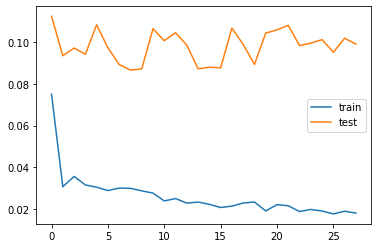

(38, 7)
(38, 7)
(38, 7)
score_train: [122.199] 131.1, 119.8, 117.3, 115.8, 116.6, 125.8, 128.1
(8, 1, 20)
score_test: [314.460] 418.2, 353.7, 119.3, 153.5, 448.8, 261.2, 291.1

RMSE test:  314.4602391117478 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0667 - val_loss: 0.1056
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.0886
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0892
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.1029
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0851
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0258 - val_loss: 0.1102
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1284
Epoch 8/1000
38/38 [======================

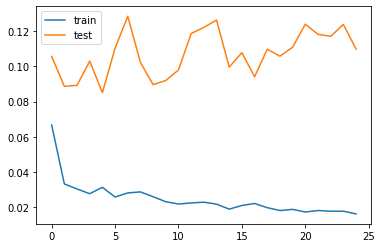

(38, 7)
(38, 7)
(38, 7)
score_train: [117.468] 123.4, 118.7, 111.0, 123.0, 114.7, 117.7, 113.2
(8, 1, 20)
score_test: [331.062] 454.5, 341.3, 89.8, 209.6, 463.3, 265.2, 327.4

RMSE test:  331.06247109819975 


Units CNN1:  189 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0599 - val_loss: 0.0771
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0844
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.0809
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0738
Epoch 5/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0901
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0740
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0253 - val_loss: 0.0749
Epoch 8/1000
38/38 [======================

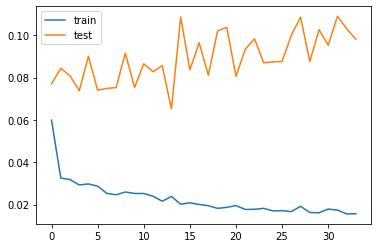

(38, 7)
(38, 7)
(38, 7)
score_train: [112.426] 125.1, 107.3, 111.7, 112.8, 106.3, 116.6, 105.9
(8, 1, 20)
score_test: [312.965] 503.9, 325.2, 132.5, 101.2, 414.0, 245.8, 257.6

RMSE test:  312.9650197476924 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0682 - val_loss: 0.0793
Epoch 2/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.1048
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0858
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0771
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0831
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0857
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.0653
Epoch 8/1000
38/38 [======================

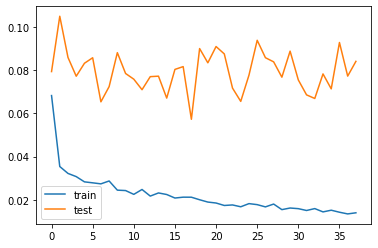

(38, 7)
(38, 7)
(38, 7)
score_train: [107.385] 106.1, 114.6, 107.2, 107.1, 100.1, 115.0, 100.6
(8, 1, 20)
score_test: [289.543] 454.1, 340.0, 47.6, 144.9, 365.5, 226.6, 238.6

RMSE test:  289.54281010570895 


Units CNN1:  125 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0640 - val_loss: 0.1076
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0353 - val_loss: 0.0782
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0909
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0813
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.0797
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0931
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.0878
Epoch 8/1000
38/38 [======================

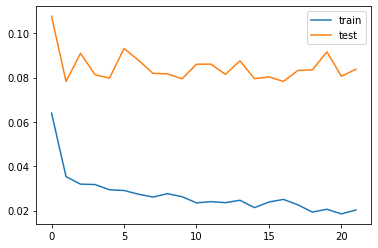

(38, 7)
(38, 7)
(38, 7)
score_train: [127.373] 135.9, 126.4, 120.8, 121.5, 119.1, 134.1, 132.5
(8, 1, 20)
score_test: [289.073] 364.0, 285.4, 116.2, 149.6, 456.3, 251.2, 252.6

RMSE test:  289.07333537572475 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0903
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0933
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.1058
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0796
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.1032
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0249 - val_loss: 0.1037
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0261 - val_loss: 0.0984
Epoch 8/1000
38/38 [=====================

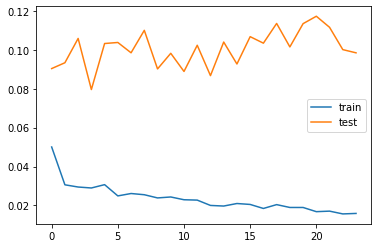

(38, 7)
(38, 7)
(38, 7)
score_train: [116.483] 122.4, 114.6, 117.5, 115.0, 112.8, 121.2, 111.4
(8, 1, 20)
score_test: [313.392] 462.9, 373.2, 98.5, 131.8, 401.4, 268.6, 271.3

RMSE test:  313.3922943874648 


Units CNN1:  191 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0468 - val_loss: 0.0698
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0889
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0341 - val_loss: 0.0889
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0710
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.0826
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0803
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.0855
Epoch 8/1000
38/38 [=======================

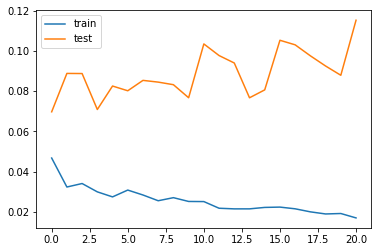

(38, 7)
(38, 7)
(38, 7)
score_train: [130.172] 133.7, 132.3, 125.9, 124.4, 118.6, 142.4, 132.5
(8, 1, 20)
score_test: [339.402] 462.6, 363.9, 73.6, 138.6, 451.5, 350.4, 329.6

RMSE test:  339.4021465757766 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0678 - val_loss: 0.0726
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0337 - val_loss: 0.0750
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0802
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0892
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.0692
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0828
Epoch 7/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0741
Epoch 8/1000
38/38 [=======================

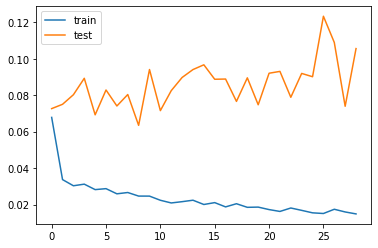

(38, 7)
(38, 7)
(38, 7)
score_train: [116.985] 113.6, 116.6, 113.7, 126.4, 111.2, 117.7, 119.1
(8, 1, 20)
score_test: [324.528] 424.1, 347.8, 78.6, 189.0, 460.5, 290.1, 313.5

RMSE test:  324.52766330567766 


Units CNN1:  223 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0657 - val_loss: 0.0944
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0976
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0780
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0836
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0799
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.0744
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0240 - val_loss: 0.0861
Epoch 8/1000
38/38 [======================

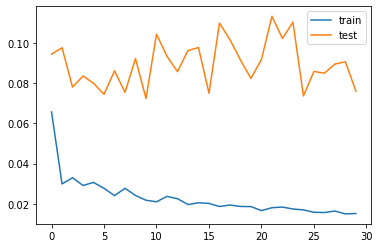

(38, 7)
(38, 7)
(38, 7)
score_train: [113.662] 117.6, 115.3, 110.8, 109.1, 104.7, 116.5, 121.0
(8, 1, 20)
score_test: [275.361] 406.3, 315.1, 86.3, 98.3, 387.1, 216.3, 229.5

RMSE test:  275.36082435599013 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0603 - val_loss: 0.0967
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0785
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.1057
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.1078
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.0885
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0257 - val_loss: 0.0861
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.1197
Epoch 8/1000
38/38 [=======================

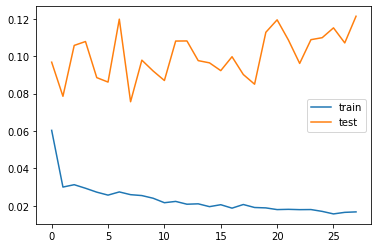

(38, 7)
(38, 7)
(38, 7)
score_train: [116.634] 121.7, 112.4, 114.3, 113.2, 118.2, 122.0, 114.3
(8, 1, 20)
score_test: [347.944] 490.9, 319.0, 123.7, 155.9, 516.4, 324.9, 304.7

RMSE test:  347.9444429584122 

gen	nevals	avg    	std   	min    	max   
0  	10    	293.844	14.172	275.361	314.46

Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0676 - val_loss: 0.0761
Epoch 2/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0723
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0929
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0893
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0939
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.0851
Epoch 7/1000
38/38 [==============================] - 0s 1ms

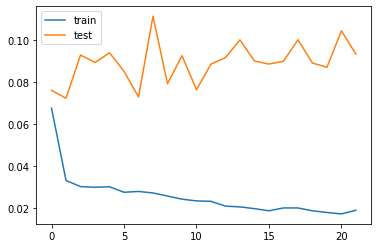

(38, 7)
(38, 7)
(38, 7)
score_train: [122.653] 127.8, 121.3, 124.4, 118.1, 113.1, 127.8, 125.3
(8, 1, 20)
score_test: [305.135] 411.5, 325.2, 101.8, 194.3, 435.8, 269.8, 256.7

RMSE test:  305.134687858968 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0840
Epoch 2/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.0882
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0724
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0878
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0843
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.0736
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.0844
Epoch 8/1000
38/38 [=======================

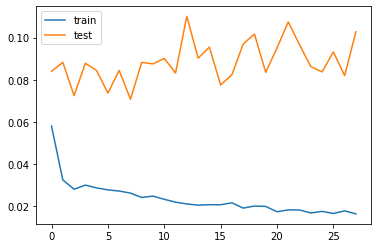

(38, 7)
(38, 7)
(38, 7)
score_train: [115.893] 119.6, 111.1, 117.2, 114.2, 113.1, 117.7, 118.1
(8, 1, 20)
score_test: [320.158] 454.3, 366.6, 101.6, 121.1, 418.8, 263.4, 327.0

RMSE test:  320.1579013944999 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0636 - val_loss: 0.0874
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0842
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0804
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0785
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.0815
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0263 - val_loss: 0.0781
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0258 - val_loss: 0.0811
Epoch 8/1000
38/38 [======================

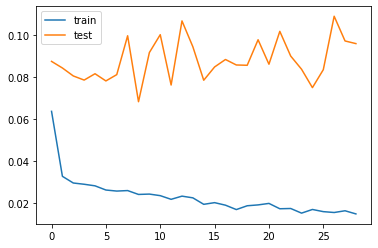

(38, 7)
(38, 7)
(38, 7)
score_train: [110.411] 114.1, 110.0, 109.4, 111.3, 109.2, 109.3, 109.4
(8, 1, 20)
score_test: [309.187] 429.6, 307.0, 154.4, 181.3, 422.4, 266.5, 290.1

RMSE test:  309.1865861304923 


Units CNN1:  223 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0540 - val_loss: 0.0819
Epoch 2/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.1110
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0350 - val_loss: 0.0957
Epoch 4/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.1051
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0947
Epoch 6/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0875
Epoch 7/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0991
Epoch 8/1000
38/38 [======================

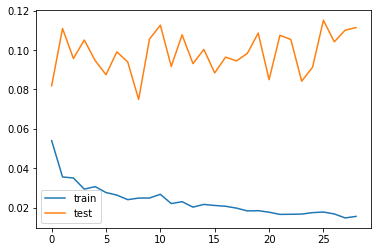

(38, 7)
(38, 7)
(38, 7)
score_train: [112.663] 118.1, 108.4, 113.6, 108.8, 114.4, 116.1, 108.8
(8, 1, 20)
score_test: [333.483] 460.4, 324.9, 120.0, 130.4, 499.5, 279.0, 319.7

RMSE test:  333.4826245847574 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 10ms/step - loss: 0.0524 - val_loss: 0.0822
Epoch 2/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0982
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0853
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0689
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0979
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.0727
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.0870
Epoch 8/1000
38/38 [=====================

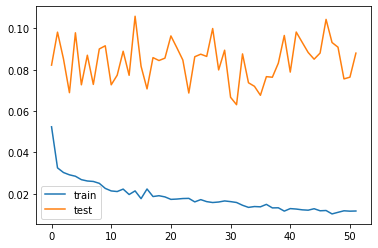

(38, 7)
(38, 7)
(38, 7)
score_train: [92.431] 88.1, 93.8, 93.6, 86.5, 94.4, 104.4, 84.7
(8, 1, 20)
score_test: [296.429] 476.1, 272.8, 84.1, 116.4, 395.2, 253.3, 270.1

RMSE test:  296.4293499288495 


Units CNN1:  187 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0656
Epoch 2/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.1061
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0832
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0810
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0814
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.0909
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0254 - val_loss: 0.0752
Epoch 8/1000
38/38 [==============================

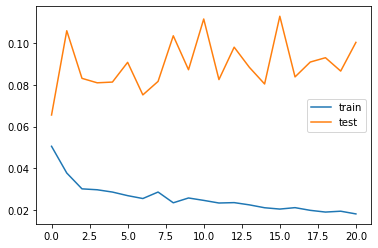

(38, 7)
(38, 7)
(38, 7)
score_train: [123.409] 130.2, 126.9, 123.2, 117.1, 114.8, 126.3, 124.7
(8, 1, 20)
score_test: [316.660] 402.9, 342.7, 60.9, 153.0, 450.0, 274.7, 342.1

RMSE test:  316.66035878610876 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0547 - val_loss: 0.0837
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0800
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0954
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.1095
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.0849
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0250 - val_loss: 0.0872
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0243 - val_loss: 0.0783
Epoch 8/1000
38/38 [======================

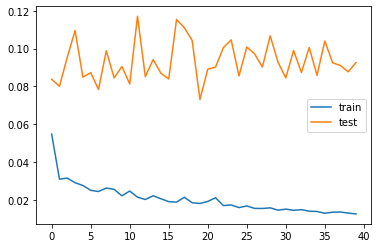

(38, 7)
(38, 7)
(38, 7)
score_train: [101.511] 101.1, 100.2, 102.0, 101.8, 103.6, 105.3, 96.4
(8, 1, 20)
score_test: [303.912] 448.9, 339.0, 109.5, 161.7, 399.0, 259.6, 255.7

RMSE test:  303.9120644163588 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0964
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.0952
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0782
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.1106
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0843
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.0921
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0257 - val_loss: 0.1044
Epoch 8/1000
38/38 [=======================

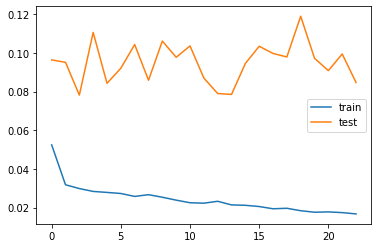

(38, 7)
(38, 7)
(38, 7)
score_train: [122.227] 121.1, 117.2, 118.2, 125.0, 116.8, 130.4, 126.1
(8, 1, 20)
score_test: [290.811] 407.6, 298.5, 128.2, 105.9, 434.5, 262.6, 226.6

RMSE test:  290.81092757068325 


Units CNN1:  127 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0678 - val_loss: 0.1104
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0355 - val_loss: 0.1251
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0362 - val_loss: 0.1051
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.1042
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.1067
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.0948
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.1022
Epoch 8/1000
38/38 [=====================

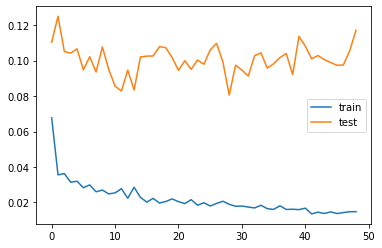

(38, 7)
(38, 7)
(38, 7)
score_train: [110.962] 116.3, 111.5, 105.2, 104.4, 105.6, 119.2, 113.5
(8, 1, 20)
score_test: [341.904] 530.0, 411.2, 75.0, 171.2, 399.1, 257.1, 328.7

RMSE test:  341.90433291433055 


Units CNN1:  239 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0529 - val_loss: 0.0830
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.0868
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.0889
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.1013
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0885
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0833
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.1123
Epoch 8/1000
38/38 [======================

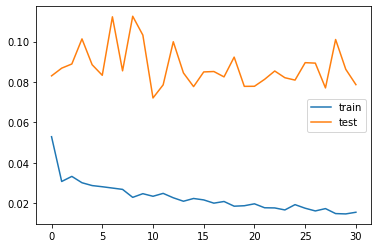

(38, 7)
(38, 7)
(38, 7)
score_train: [111.089] 117.0, 108.4, 108.5, 111.5, 111.9, 114.5, 105.4
(8, 1, 20)
score_test: [280.179] 402.2, 300.1, 113.3, 100.4, 384.0, 247.3, 257.2

RMSE test:  280.1792730087581 

1  	10    	275.361	0     	275.361	275.361

Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0795
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0343 - val_loss: 0.0884
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0796
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0887
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0925
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.0785
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.0931


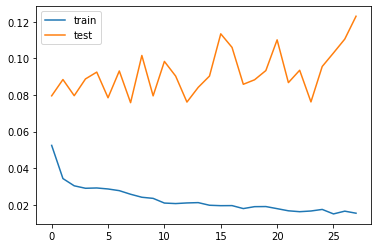

(38, 7)
(38, 7)
(38, 7)
score_train: [117.139] 115.5, 121.9, 118.9, 119.2, 108.8, 121.0, 114.1
(8, 1, 20)
score_test: [350.315] 485.1, 414.2, 55.7, 188.9, 450.6, 304.8, 342.7

RMSE test:  350.3152999484501 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0530 - val_loss: 0.0729
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0814
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0805
Epoch 4/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0610
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0882
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.0581
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0260 - val_loss: 0.0813
Epoch 8/1000
38/38 [=======================

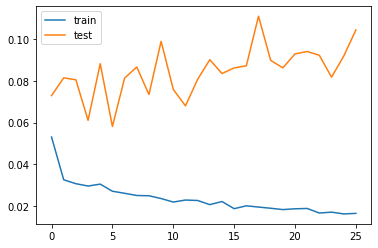

(38, 7)
(38, 7)
(38, 7)
score_train: [119.794] 127.9, 121.0, 121.9, 116.8, 109.4, 123.2, 117.5
(8, 1, 20)
score_test: [322.854] 504.0, 385.8, 27.5, 158.3, 386.2, 268.8, 282.2

RMSE test:  322.85381792844447 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0572 - val_loss: 0.0865
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0719
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.0835
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.0896
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.0781
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.0944
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0255 - val_loss: 0.0824
Epoch 8/1000
38/38 [======================

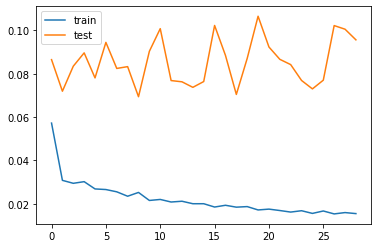

(38, 7)
(38, 7)
(38, 7)
score_train: [110.524] 113.8, 110.6, 113.2, 109.8, 106.8, 114.3, 104.8
(8, 1, 20)
score_test: [308.909] 440.5, 356.3, 112.9, 148.5, 390.7, 284.5, 280.3

RMSE test:  308.9089814308256 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0744
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0346 - val_loss: 0.0914
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.1014
Epoch 4/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0855
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0908
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0264 - val_loss: 0.0790
Epoch 7/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0828
Epoch 8/1000
38/38 [======================

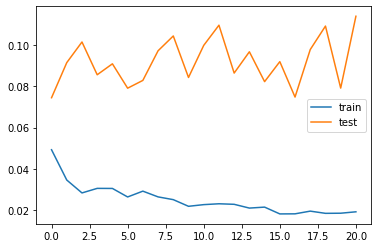

(38, 7)
(38, 7)
(38, 7)
score_train: [125.710] 131.0, 124.8, 121.3, 121.2, 122.7, 121.7, 136.3
(8, 1, 20)
score_test: [337.012] 431.7, 305.9, 92.0, 181.8, 505.6, 290.2, 365.7

RMSE test:  337.01203720182224 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0552 - val_loss: 0.0674
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0875
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0881
Epoch 4/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0916
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0948
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.0830
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0923
Epoch 8/1000
38/38 [======================

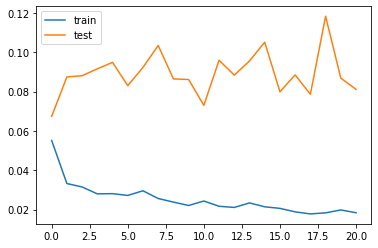

(38, 7)
(38, 7)
(38, 7)
score_train: [122.120] 126.2, 125.4, 121.7, 118.2, 112.9, 121.7, 128.1
(8, 1, 20)
score_test: [284.578] 407.3, 305.9, 138.4, 114.9, 414.4, 239.5, 214.6

RMSE test:  284.5782201021723 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0489 - val_loss: 0.0886
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.1036
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0963
Epoch 4/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0874
Epoch 5/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.1096
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0265 - val_loss: 0.0947
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0258 - val_loss: 0.0819
Epoch 8/1000
38/38 [======================

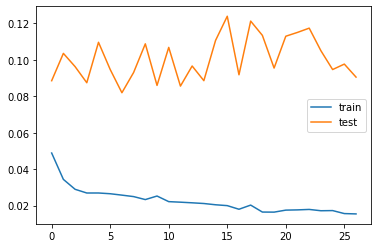

(38, 7)
(38, 7)
(38, 7)
score_train: [118.852] 126.5, 127.0, 113.0, 110.6, 110.2, 122.6, 120.6
(8, 1, 20)
score_test: [300.582] 421.8, 300.8, 124.9, 158.0, 450.4, 252.2, 238.6

RMSE test:  300.5822646324685 


Units CNN1:  253 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0574 - val_loss: 0.0760
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0359 - val_loss: 0.0864
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.1167
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0858
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.0825
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0954
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0259 - val_loss: 0.0874
Epoch 8/1000
38/38 [======================

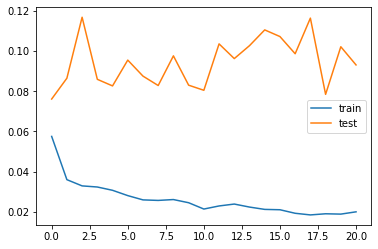

(38, 7)
(38, 7)
(38, 7)
score_train: [124.261] 133.3, 123.9, 121.4, 122.4, 116.7, 126.5, 125.0
(8, 1, 20)
score_test: [304.613] 390.4, 316.9, 104.1, 137.8, 439.2, 294.2, 295.6

RMSE test:  304.6131075318144 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0495 - val_loss: 0.0802
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0822
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0773
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0646
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0831
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0246 - val_loss: 0.0809
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0244 - val_loss: 0.0856
Epoch 8/1000
38/38 [======================

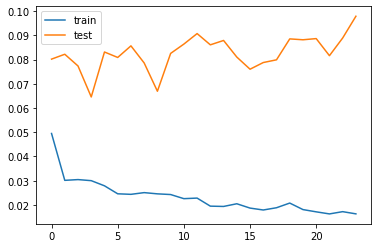

(38, 7)
(38, 7)
(38, 7)
score_train: [116.573] 123.0, 117.9, 113.3, 113.1, 117.7, 117.0, 113.8
(8, 1, 20)
score_test: [312.532] 413.9, 332.3, 107.5, 118.0, 476.8, 284.3, 261.5

RMSE test:  312.53167238907065 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0495 - val_loss: 0.0902
Epoch 2/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0966
Epoch 3/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0968
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.1031
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0865
Epoch 6/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0841
Epoch 7/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.1114
Epoch 8/1000
38/38 [=====================

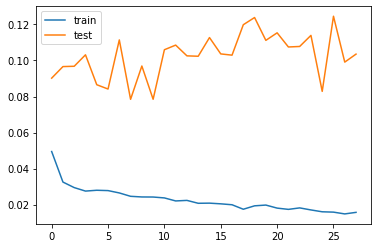

(38, 7)
(38, 7)
(38, 7)
score_train: [111.931] 113.9, 110.2, 113.7, 107.5, 108.0, 118.4, 111.4
(8, 1, 20)
score_test: [321.431] 439.6, 337.1, 96.5, 115.6, 468.3, 281.4, 308.6

RMSE test:  321.4307110870344 

2  	9     	275.361	0     	275.361	275.361

Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 11ms/step - loss: 0.0672 - val_loss: 0.0876
Epoch 2/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.1210
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.1079
Epoch 4/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0897
Epoch 5/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.1131
Epoch 6/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0885
Epoch 7/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.1113


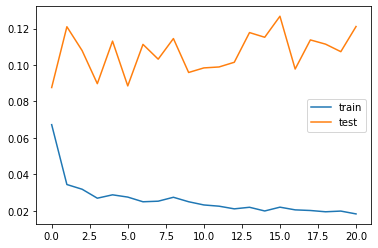

(38, 7)
(38, 7)
(38, 7)
score_train: [126.875] 132.5, 125.0, 116.6, 121.8, 118.7, 133.1, 138.8
(8, 1, 20)
score_test: [347.659] 439.3, 383.4, 123.0, 194.0, 492.6, 291.1, 354.9

RMSE test:  347.6589057468293 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0764 - val_loss: 0.0932
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0972
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0957
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0806
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0818
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0258 - val_loss: 0.1047
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0243 - val_loss: 0.0964
Epoch 8/1000
38/38 [======================

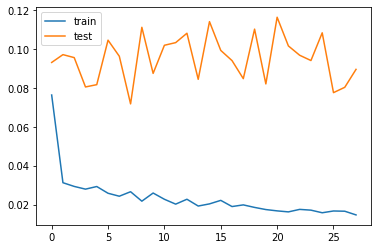

(38, 7)
(38, 7)
(38, 7)
score_train: [111.146] 112.5, 111.2, 112.5, 107.1, 109.6, 117.2, 107.8
(8, 1, 20)
score_test: [299.123] 446.1, 337.5, 125.1, 114.9, 390.8, 255.9, 257.6

RMSE test:  299.12291725738726 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0456 - val_loss: 0.0722
Epoch 2/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0970
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.1173
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0753
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0786
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.0990
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0250 - val_loss: 0.0878
Epoch 8/1000
38/38 [=====================

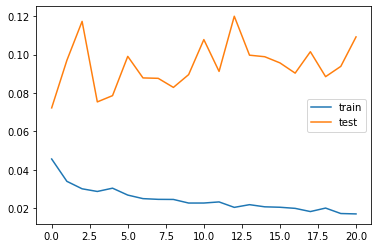

(38, 7)
(38, 7)
(38, 7)
score_train: [122.637] 125.1, 123.9, 123.9, 125.1, 116.6, 124.5, 119.1
(8, 1, 20)
score_test: [330.092] 421.4, 346.2, 36.5, 218.1, 465.2, 324.0, 308.3

RMSE test:  330.0917540382932 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0548 - val_loss: 0.0798
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0953
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0856
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0635
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0960
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.0960
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0242 - val_loss: 0.0817
Epoch 8/1000
38/38 [=======================

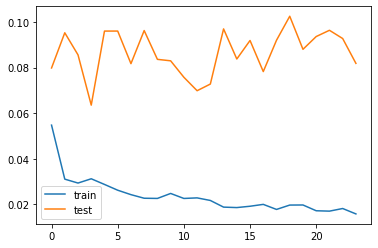

(38, 7)
(38, 7)
(38, 7)
score_train: [115.900] 123.0, 116.7, 113.6, 112.6, 111.1, 119.7, 114.2
(8, 1, 20)
score_test: [285.834] 413.0, 305.4, 128.7, 96.9, 404.2, 230.2, 256.3

RMSE test:  285.8338362326375 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0536 - val_loss: 0.0608
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0735
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0728
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0818
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.0755
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.0677
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0256 - val_loss: 0.1101
Epoch 8/1000
38/38 [=======================

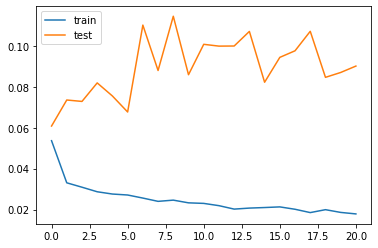

(38, 7)
(38, 7)
(38, 7)
score_train: [119.572] 128.9, 116.3, 117.6, 114.5, 112.6, 124.3, 121.9
(8, 1, 20)
score_test: [299.817] 454.0, 315.7, 62.1, 149.5, 397.6, 258.7, 268.8

RMSE test:  299.8174328395179 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0528 - val_loss: 0.0893
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0910
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0826
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0866
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0848
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0264 - val_loss: 0.1099
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0695
Epoch 8/1000
38/38 [=======================

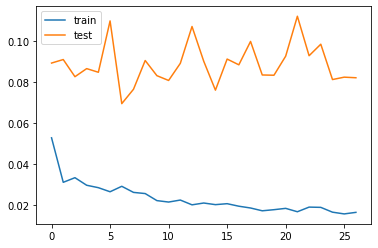

(38, 7)
(38, 7)
(38, 7)
score_train: [117.860] 121.3, 114.7, 114.6, 111.6, 108.9, 120.8, 131.7
(8, 1, 20)
score_test: [286.283] 435.9, 299.3, 108.3, 172.4, 388.7, 237.8, 212.2

RMSE test:  286.28270426379544 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0513 - val_loss: 0.0776
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0904
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0927
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0958
Epoch 5/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0874
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0743
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.0957
Epoch 8/1000
38/38 [=====================

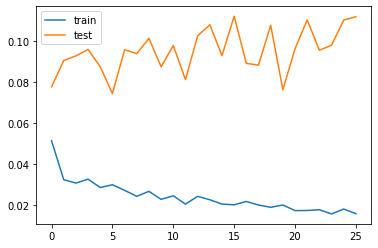

(38, 7)
(38, 7)
(38, 7)
score_train: [118.377] 118.4, 124.0, 118.7, 114.9, 111.8, 122.8, 117.5
(8, 1, 20)
score_test: [334.050] 489.6, 351.5, 88.0, 172.4, 463.8, 278.4, 296.3

RMSE test:  334.04994599164286 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0572 - val_loss: 0.0932
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0993
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0859
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.0854
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.0929
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0941
Epoch 7/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0277 - val_loss: 0.0634
Epoch 8/1000
38/38 [======================

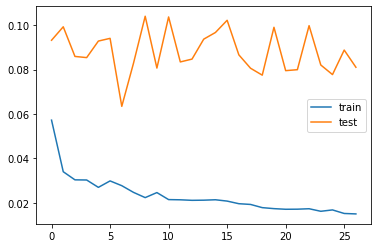

(38, 7)
(38, 7)
(38, 7)
score_train: [113.806] 115.8, 118.5, 110.7, 113.0, 105.1, 114.9, 118.0
(8, 1, 20)
score_test: [284.405] 407.1, 281.3, 115.4, 121.9, 392.5, 279.0, 247.6

RMSE test:  284.4047402237543 

3  	8     	275.361	0     	275.361	275.361

Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 11ms/step - loss: 0.0569 - val_loss: 0.0699
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.1087
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0815
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.1031
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0577
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0913
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0246 - val_loss: 0.0782

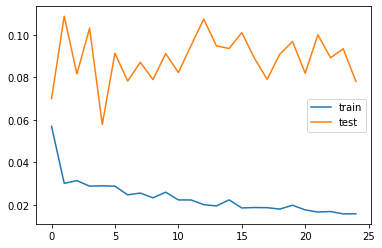

(38, 7)
(38, 7)
(38, 7)
score_train: [113.515] 121.4, 109.8, 116.3, 110.4, 106.3, 118.0, 111.7
(8, 1, 20)
score_test: [279.093] 385.5, 280.9, 92.8, 163.9, 409.1, 252.0, 226.7

RMSE test:  279.0928287859905 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0632 - val_loss: 0.0819
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0948
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.0771
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.0912
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0788
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.1087
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0265 - val_loss: 0.0743
Epoch 8/1000
38/38 [=======================

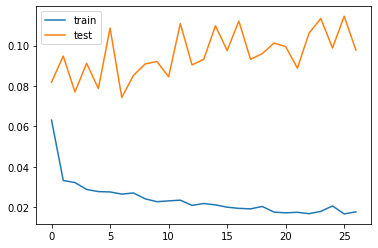

(38, 7)
(38, 7)
(38, 7)
score_train: [116.334] 120.6, 118.8, 116.1, 117.6, 109.6, 118.2, 113.1
(8, 1, 20)
score_test: [312.397] 468.7, 331.8, 154.1, 79.4, 417.0, 287.1, 258.8

RMSE test:  312.39654508030907 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0511 - val_loss: 0.0670
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0834
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0757
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0746
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.0774
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.1069
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0240 - val_loss: 0.0589
Epoch 8/1000
38/38 [======================

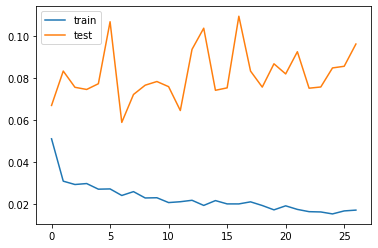

(38, 7)
(38, 7)
(38, 7)
score_train: [117.556] 130.0, 114.7, 120.4, 116.5, 110.6, 121.3, 108.1
(8, 1, 20)
score_test: [310.025] 484.6, 331.2, 60.8, 159.5, 414.8, 272.9, 229.4

RMSE test:  310.0247648375229 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0539 - val_loss: 0.0625
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0750
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0715
Epoch 4/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0856
Epoch 5/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0705
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.0736
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0252 - val_loss: 0.0815
Epoch 8/1000
38/38 [=======================

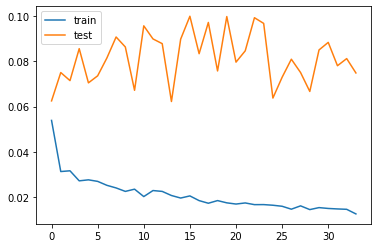

(38, 7)
(38, 7)
(38, 7)
score_train: [106.583] 110.0, 113.4, 108.6, 103.2, 101.4, 107.8, 101.1
(8, 1, 20)
score_test: [273.346] 442.6, 281.7, 130.8, 61.9, 338.2, 214.4, 257.8

RMSE test:  273.3455469160201 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0418 - val_loss: 0.0824
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0346 - val_loss: 0.0895
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0958
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0872
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0972
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.0943
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0260 - val_loss: 0.0969
Epoch 8/1000
38/38 [=======================

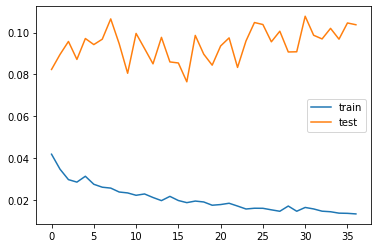

(38, 7)
(38, 7)
(38, 7)
score_train: [106.797] 103.1, 103.0, 110.6, 103.6, 110.6, 110.1, 106.2
(8, 1, 20)
score_test: [321.816] 463.1, 291.8, 109.4, 127.6, 456.2, 276.4, 335.4

RMSE test:  321.81604426503293 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0582 - val_loss: 0.0764
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.0796
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0750
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.1034
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0766
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0821
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0257 - val_loss: 0.0757
Epoch 8/1000
38/38 [=====================

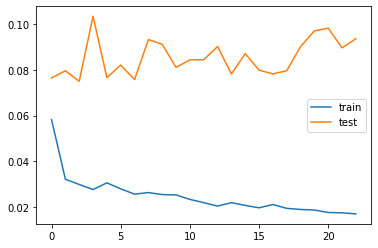

(38, 7)
(38, 7)
(38, 7)
score_train: [120.811] 129.5, 122.4, 117.5, 117.1, 115.3, 123.6, 119.6
(8, 1, 20)
score_test: [305.619] 400.8, 309.0, 80.9, 108.6, 441.3, 347.5, 252.7

RMSE test:  305.6187563652176 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0586 - val_loss: 0.0838
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0353 - val_loss: 0.1077
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0988
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0866
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0890
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0265 - val_loss: 0.1013
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0257 - val_loss: 0.0996
Epoch 8/1000
38/38 [=======================

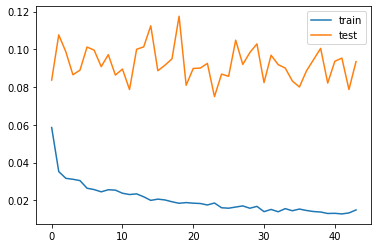

(38, 7)
(38, 7)
(38, 7)
score_train: [101.456] 104.0, 97.5, 105.9, 102.5, 99.2, 107.3, 93.0
(8, 1, 20)
score_test: [305.514] 490.2, 323.5, 154.3, 49.8, 365.3, 255.5, 288.9

RMSE test:  305.5143933417193 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0534 - val_loss: 0.0793
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0853
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0748
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.0817
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.0660
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0749
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0238 - val_loss: 0.0856
Epoch 8/1000
38/38 [==========================

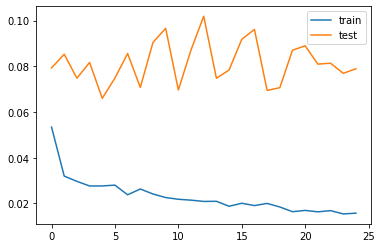

(38, 7)
(38, 7)
(38, 7)
score_train: [114.132] 116.9, 115.2, 115.4, 108.3, 110.8, 121.3, 110.5
(8, 1, 20)
score_test: [280.602] 447.5, 311.6, 149.5, 103.0, 379.9, 197.1, 194.2

RMSE test:  280.6023469475404 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 11ms/step - loss: 0.0519 - val_loss: 0.0802
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0969
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.0810
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0951
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.0646
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0256 - val_loss: 0.0827
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.1040
Epoch 8/1000
38/38 [=====================

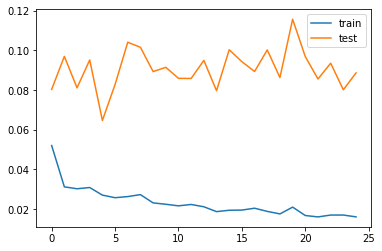

(38, 7)
(38, 7)
(38, 7)
score_train: [116.168] 123.5, 118.2, 112.1, 114.8, 110.3, 117.4, 116.4
(8, 1, 20)
score_test: [297.301] 404.1, 265.9, 140.2, 134.1, 458.0, 276.6, 246.7

RMSE test:  297.3013266068083 

4  	9     	274.152	0.98728	273.346	275.361

Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0630 - val_loss: 0.0924
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0817
Epoch 3/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.0788
Epoch 4/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0908
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.0804
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.0851
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0254 - val_loss: 0.0792

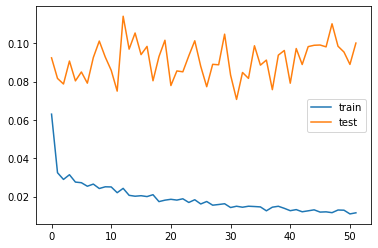

(38, 7)
(38, 7)
(38, 7)
score_train: [95.273] 93.6, 98.2, 97.4, 93.0, 90.1, 103.7, 90.1
(8, 1, 20)
score_test: [316.115] 503.7, 384.5, 108.8, 61.8, 347.6, 253.4, 312.0

RMSE test:  316.11504881669117 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0585 - val_loss: 0.0698
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0915
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0768
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0834
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0875
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0787
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.0740
Epoch 8/1000
38/38 [=============================

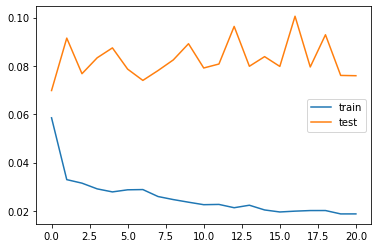

(38, 7)
(38, 7)
(38, 7)
score_train: [120.851] 126.4, 117.7, 117.4, 116.9, 114.9, 126.2, 125.9
(8, 1, 20)
score_test: [275.304] 422.9, 283.5, 147.1, 120.3, 393.9, 219.5, 178.5

RMSE test:  275.3038567721409 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0459 - val_loss: 0.0587
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0345 - val_loss: 0.0904
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0919
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0937
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.1102
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0248 - val_loss: 0.0946
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0244 - val_loss: 0.1049
Epoch 8/1000
38/38 [======================

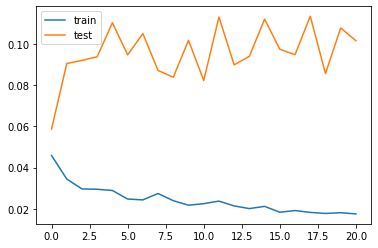

(38, 7)
(38, 7)
(38, 7)
score_train: [119.030] 125.4, 121.4, 118.1, 115.0, 115.5, 121.0, 116.5
(8, 1, 20)
score_test: [318.186] 462.8, 287.5, 137.9, 171.9, 473.1, 266.5, 261.7

RMSE test:  318.18646880897575 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0588 - val_loss: 0.0849
Epoch 2/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0955
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.1156
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.1016
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0892
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0709
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.1021
Epoch 8/1000
38/38 [=====================

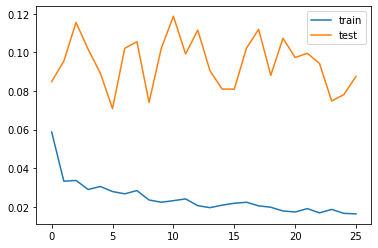

(38, 7)
(38, 7)
(38, 7)
score_train: [115.427] 121.9, 118.4, 114.1, 110.4, 110.8, 119.3, 112.6
(8, 1, 20)
score_test: [295.732] 427.7, 327.6, 74.3, 157.2, 410.8, 241.6, 254.1

RMSE test:  295.7323446547495 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0477 - val_loss: 0.0771
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.0773
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0836
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0849
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.0956
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0263 - val_loss: 0.0755
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0250 - val_loss: 0.0779
Epoch 8/1000
38/38 [=======================

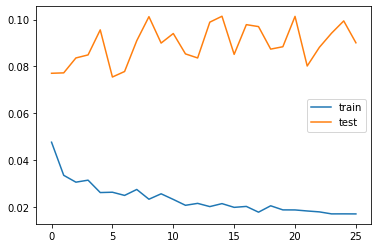

(38, 7)
(38, 7)
(38, 7)
score_train: [117.437] 122.8, 115.6, 114.3, 120.4, 113.4, 118.3, 117.0
(8, 1, 20)
score_test: [299.883] 444.2, 301.8, 160.1, 118.1, 432.0, 245.6, 233.8

RMSE test:  299.8826680683001 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0843
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0338 - val_loss: 0.0760
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0759
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0736
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0892
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0917
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0242 - val_loss: 0.0710
Epoch 8/1000
38/38 [======================

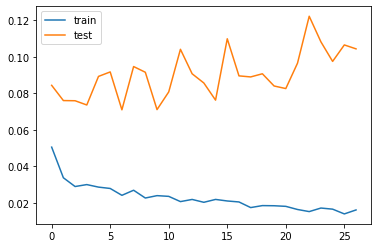

(38, 7)
(38, 7)
(38, 7)
score_train: [113.413] 121.1, 112.6, 115.0, 107.3, 110.0, 118.7, 108.5
(8, 1, 20)
score_test: [322.599] 476.3, 358.6, 102.7, 99.4, 435.9, 291.8, 278.4

RMSE test:  322.5989132392137 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0554 - val_loss: 0.0723
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0667
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0729
Epoch 4/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0618
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.0809
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.0786
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0250 - val_loss: 0.0652
Epoch 8/1000
38/38 [=======================

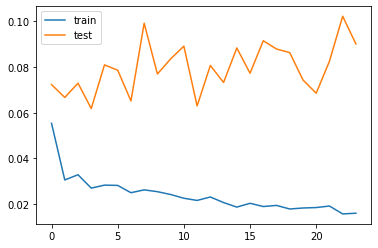

(38, 7)
(38, 7)
(38, 7)
score_train: [117.869] 125.3, 118.6, 119.2, 118.2, 113.0, 115.1, 115.4
(8, 1, 20)
score_test: [299.778] 479.1, 331.8, 80.1, 189.1, 373.5, 213.9, 249.0

RMSE test:  299.7776889445764 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 11ms/step - loss: 0.0435 - val_loss: 0.0732
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.1093
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0913
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0805
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0839
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0955
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.0790
Epoch 8/1000
38/38 [======================

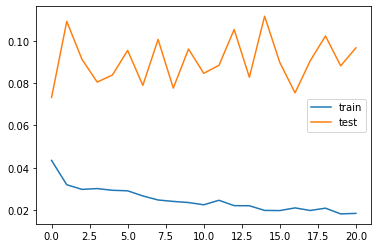

(38, 7)
(38, 7)
(38, 7)
score_train: [122.071] 127.1, 123.2, 119.3, 119.2, 117.2, 123.5, 124.6
(8, 1, 20)
score_test: [310.718] 426.3, 293.6, 78.3, 157.6, 443.7, 302.8, 297.2

RMSE test:  310.7178946290931 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0484 - val_loss: 0.0622
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.0863
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0560
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0840
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.0713
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0712
Epoch 7/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0840
Epoch 8/1000
38/38 [=======================

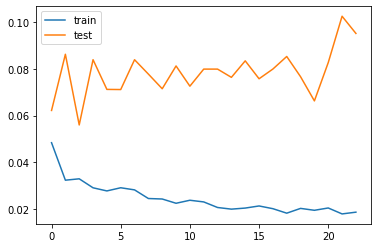

(38, 7)
(38, 7)
(38, 7)
score_train: [120.833] 126.4, 116.8, 119.9, 124.3, 117.7, 121.3, 119.1
(8, 1, 20)
score_test: [308.404] 441.8, 341.8, 104.7, 166.2, 436.3, 248.2, 251.4

RMSE test:  308.4037849395703 

5  	9     	273.346	5.68434e-14	273.346	273.346

Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0515 - val_loss: 0.0719
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0822
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0683
Epoch 4/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0753
Epoch 5/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.1019
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.0996
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0253 - val_loss: 0.

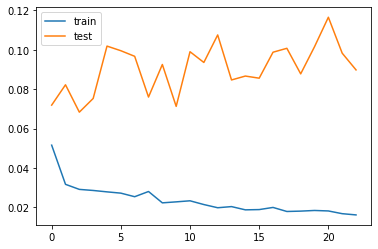

(38, 7)
(38, 7)
(38, 7)
score_train: [117.053] 118.4, 114.0, 117.3, 113.1, 121.6, 120.4, 114.2
(8, 1, 20)
score_test: [299.367] 454.3, 355.6, 165.5, 107.3, 356.7, 251.3, 255.4

RMSE test:  299.36709861965676 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0544 - val_loss: 0.0728
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.0790
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0909
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0888
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0938
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0864
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0260 - val_loss: 0.0730
Epoch 8/1000
38/38 [=====================

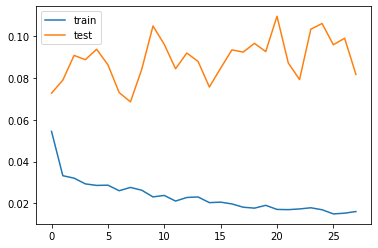

(38, 7)
(38, 7)
(38, 7)
score_train: [115.378] 115.3, 115.8, 110.5, 120.6, 116.4, 119.8, 108.7
(8, 1, 20)
score_test: [285.681] 465.6, 292.9, 124.0, 116.1, 358.2, 219.0, 252.1

RMSE test:  285.68133829201804 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 0.0632
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0807
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0864
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.0877
Epoch 5/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0289 - val_loss: 0.0784
Epoch 6/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0589
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0257 - val_loss: 0.0859
Epoch 8/1000
38/38 [=====================

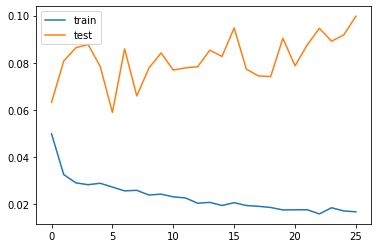

(38, 7)
(38, 7)
(38, 7)
score_train: [118.002] 122.0, 116.6, 117.0, 120.7, 121.6, 116.1, 111.6
(8, 1, 20)
score_test: [315.437] 425.7, 346.2, 125.5, 189.7, 448.1, 250.5, 283.0

RMSE test:  315.43703201389746 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0616 - val_loss: 0.0803
Epoch 2/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0996
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.0999
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.0998
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.1137
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0261 - val_loss: 0.1093
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0260 - val_loss: 0.0911
Epoch 8/1000
38/38 [=====================

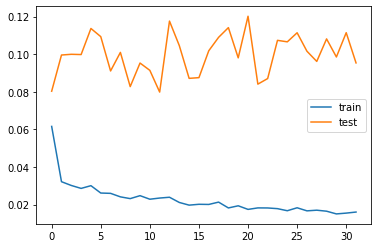

(38, 7)
(38, 7)
(38, 7)
score_train: [110.595] 115.1, 109.5, 110.2, 112.4, 108.3, 112.4, 106.1
(8, 1, 20)
score_test: [308.488] 448.2, 353.6, 155.7, 116.9, 439.6, 261.1, 202.2

RMSE test:  308.487519953916 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0633 - val_loss: 0.0902
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0662
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0937
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0760
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0863
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.0601
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.0801
Epoch 8/1000
38/38 [=======================

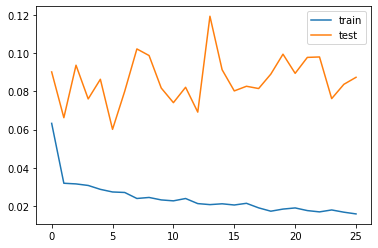

(38, 7)
(38, 7)
(38, 7)
score_train: [114.040] 118.2, 111.8, 116.1, 112.6, 107.5, 118.3, 113.4
(8, 1, 20)
score_test: [295.247] 440.7, 303.9, 116.9, 134.1, 385.2, 242.4, 291.3

RMSE test:  295.2474255296929 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0534 - val_loss: 0.0760
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0343 - val_loss: 0.0916
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0833
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0963
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.0828
Epoch 6/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0926
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.0938
Epoch 8/1000
38/38 [======================

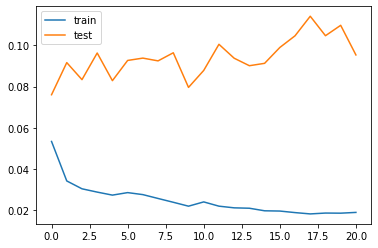

(38, 7)
(38, 7)
(38, 7)
score_train: [121.685] 126.8, 120.0, 120.2, 115.9, 114.4, 126.5, 127.3
(8, 1, 20)
score_test: [308.411] 411.9, 322.5, 117.2, 134.5, 432.0, 301.2, 288.2

RMSE test:  308.4114101538817 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0527 - val_loss: 0.0825
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0852
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0818
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0905
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.0838
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0261 - val_loss: 0.0805
Epoch 7/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0928
Epoch 8/1000
38/38 [======================

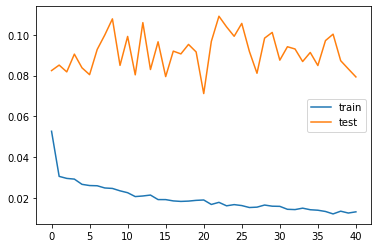

(38, 7)
(38, 7)
(38, 7)
score_train: [102.661] 107.1, 103.1, 103.8, 102.8, 97.0, 105.2, 99.3
(8, 1, 20)
score_test: [281.419] 421.8, 312.8, 154.7, 105.0, 367.2, 255.9, 208.2

RMSE test:  281.41934475085725 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0489 - val_loss: 0.0658
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.0905
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0788
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0722
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.0819
Epoch 6/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0835
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0257 - val_loss: 0.0689
Epoch 8/1000
38/38 [=======================

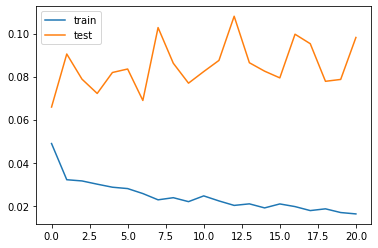

(38, 7)
(38, 7)
(38, 7)
score_train: [122.791] 134.1, 126.8, 117.6, 117.2, 122.5, 119.0, 121.6
(8, 1, 20)
score_test: [312.993] 445.1, 325.5, 86.9, 155.1, 469.4, 243.3, 265.6

RMSE test:  312.9932157246998 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0539 - val_loss: 0.0675
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0742
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.0677
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0733
Epoch 5/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0747
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.0689
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0249 - val_loss: 0.0720
Epoch 8/1000
38/38 [=======================

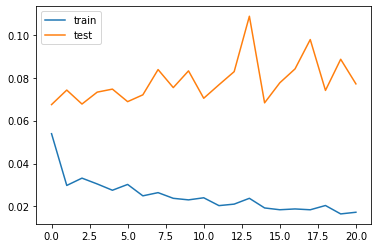

(38, 7)
(38, 7)
(38, 7)
score_train: [121.054] 125.5, 121.4, 123.2, 125.4, 115.6, 121.4, 114.4
(8, 1, 20)
score_test: [277.466] 388.9, 324.8, 78.6, 166.1, 388.0, 229.2, 213.0

RMSE test:  277.46598359797406 

6  	9     	273.346	5.68434e-14	273.346	273.346

Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0631 - val_loss: 0.0707
Epoch 2/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0894
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0866
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.0818
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0815
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0894
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0252 - val_loss: 0.

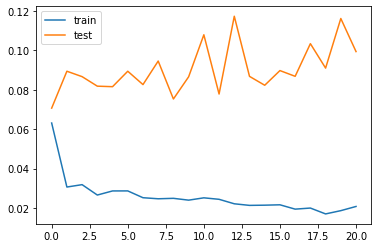

(38, 7)
(38, 7)
(38, 7)
score_train: [123.797] 127.9, 123.2, 121.1, 120.7, 117.5, 128.6, 127.1
(8, 1, 20)
score_test: [314.859] 396.8, 336.7, 80.8, 179.1, 472.3, 283.5, 284.7

RMSE test:  314.8592523377578 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0539 - val_loss: 0.0771
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0913
Epoch 3/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0774
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1043
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.0874
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0263 - val_loss: 0.0916
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0248 - val_loss: 0.0911
Epoch 8/1000
38/38 [=======================

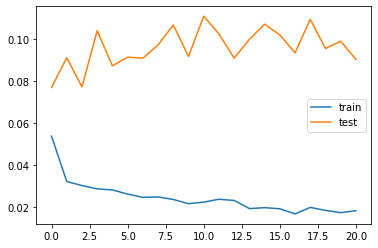

(38, 7)
(38, 7)
(38, 7)
score_train: [120.311] 125.6, 124.2, 115.5, 116.6, 111.3, 124.2, 124.1
(8, 1, 20)
score_test: [300.514] 418.6, 308.7, 131.1, 111.4, 462.9, 254.3, 230.4

RMSE test:  300.51436513676765 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0594 - val_loss: 0.0778
Epoch 2/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0946
Epoch 3/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0863
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0951
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0696
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0875
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.0704
Epoch 8/1000
38/38 [=====================

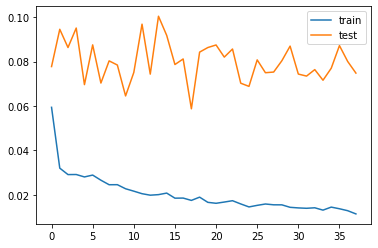

(38, 7)
(38, 7)
(38, 7)
score_train: [104.961] 97.8, 98.4, 104.3, 115.7, 112.3, 107.7, 96.9
(8, 1, 20)
score_test: [273.285] 464.5, 322.8, 176.2, 45.3, 292.0, 196.0, 214.6

RMSE test:  273.28461610493036 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0529 - val_loss: 0.0782
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.1020
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0782
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.1052
Epoch 5/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0724
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.0934
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0258 - val_loss: 0.0893
Epoch 8/1000
38/38 [=========================

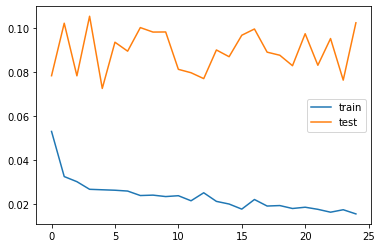

(38, 7)
(38, 7)
(38, 7)
score_train: [114.281] 120.7, 111.9, 112.6, 113.7, 109.2, 119.3, 112.1
(8, 1, 20)
score_test: [319.432] 475.6, 307.2, 142.5, 100.0, 453.4, 273.0, 288.6

RMSE test:  319.43178114376235 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0552 - val_loss: 0.0679
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0776
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0672
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.0754
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0253 - val_loss: 0.0806
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0253 - val_loss: 0.0689
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.0783
Epoch 8/1000
38/38 [=====================

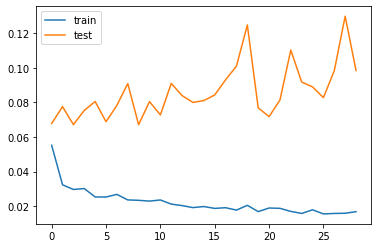

(38, 7)
(38, 7)
(38, 7)
score_train: [112.766] 116.7, 119.9, 116.9, 110.3, 107.4, 114.6, 102.6
(8, 1, 20)
score_test: [313.530] 447.4, 387.5, 44.8, 117.3, 393.2, 262.6, 313.8

RMSE test:  313.5304543544846 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0622 - val_loss: 0.0809
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0351 - val_loss: 0.0853
Epoch 3/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0911
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0865
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0891
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0858
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0261 - val_loss: 0.0842
Epoch 8/1000
38/38 [=======================

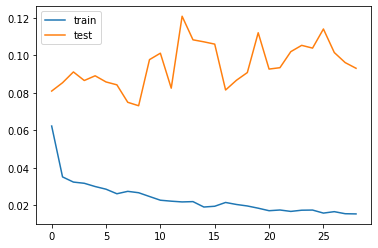

(38, 7)
(38, 7)
(38, 7)
score_train: [112.986] 120.3, 113.1, 109.6, 113.6, 103.6, 118.0, 111.9
(8, 1, 20)
score_test: [304.751] 420.8, 296.9, 120.0, 181.3, 431.8, 259.6, 289.5

RMSE test:  304.75091502319907 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 11ms/step - loss: 0.0462 - val_loss: 0.0733
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0354 - val_loss: 0.1022
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0866
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0776
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.0834
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.0809
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0264 - val_loss: 0.0780
Epoch 8/1000
38/38 [====================

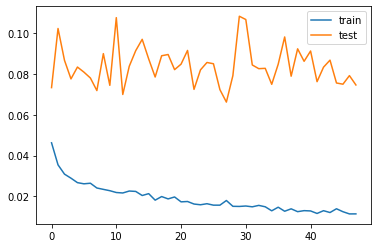

(38, 7)
(38, 7)
(38, 7)
score_train: [99.511] 100.2, 101.6, 102.8, 97.9, 93.2, 108.8, 91.0
(8, 1, 20)
score_test: [272.819] 452.2, 279.9, 135.9, 31.8, 327.9, 207.9, 260.6

RMSE test:  272.8193486740372 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0526 - val_loss: 0.0827
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0994
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.1079
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.0967
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0709
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0258 - val_loss: 0.1062
Epoch 7/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.1036
Epoch 8/1000
38/38 [===========================

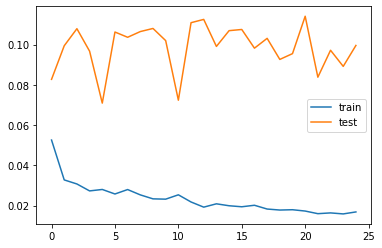

(38, 7)
(38, 7)
(38, 7)
score_train: [113.846] 122.1, 113.9, 113.4, 112.3, 109.4, 114.7, 110.7
(8, 1, 20)
score_test: [315.172] 437.7, 320.6, 69.9, 167.9, 474.2, 273.7, 261.0

RMSE test:  315.17203822577864 

7  	8     	273.216	0.200157   	272.819	273.346

Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0569 - val_loss: 0.0860
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0865
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0926
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.0870
Epoch 5/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0977
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.0900
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.

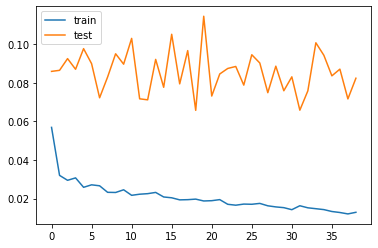

(38, 7)
(38, 7)
(38, 7)
score_train: [103.208] 103.0, 101.0, 105.4, 107.7, 101.0, 108.5, 95.2
(8, 1, 20)
score_test: [286.790] 402.1, 299.2, 95.4, 161.6, 402.3, 224.2, 277.8

RMSE test:  286.79038934192306 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0547 - val_loss: 0.0798
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0867
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0875
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0747
Epoch 5/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.1001
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0252 - val_loss: 0.0946
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0263 - val_loss: 0.0862
Epoch 8/1000
38/38 [=======================

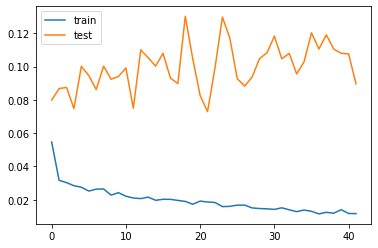

(38, 7)
(38, 7)
(38, 7)
score_train: [102.077] 93.4, 95.0, 101.2, 99.8, 115.6, 110.4, 97.0
(8, 1, 20)
score_test: [298.971] 487.8, 423.1, 121.1, 96.4, 297.5, 181.5, 251.7

RMSE test:  298.97052615111147 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0498 - val_loss: 0.0751
Epoch 2/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0988
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.0833
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0849
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0715
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0933
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0247 - val_loss: 0.0884
Epoch 8/1000
38/38 [==========================

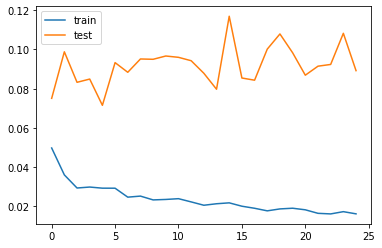

(38, 7)
(38, 7)
(38, 7)
score_train: [115.338] 122.1, 116.6, 115.0, 113.6, 112.0, 116.5, 111.2
(8, 1, 20)
score_test: [298.398] 427.5, 308.2, 90.3, 127.1, 378.3, 318.4, 277.1

RMSE test:  298.3984608488879 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0539 - val_loss: 0.0830
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0747
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0951
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0728
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0873
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.1097
Epoch 7/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0601
Epoch 8/1000
38/38 [=======================

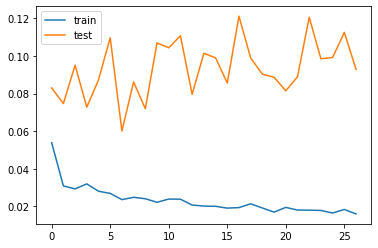

(38, 7)
(38, 7)
(38, 7)
score_train: [117.226] 123.6, 116.4, 117.2, 117.1, 108.7, 120.6, 116.4
(8, 1, 20)
score_test: [304.539] 455.0, 332.7, 128.9, 121.3, 407.1, 238.7, 278.3

RMSE test:  304.5386469182045 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0621 - val_loss: 0.0741
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0760
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0892
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0696
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0713
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.0809
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.0802
Epoch 8/1000
38/38 [======================

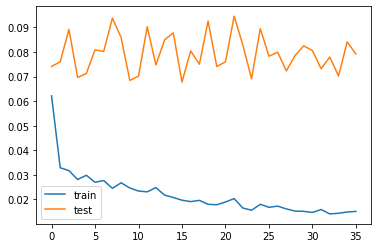

(38, 7)
(38, 7)
(38, 7)
score_train: [107.064] 110.2, 105.9, 115.2, 102.6, 104.7, 109.3, 100.8
(8, 1, 20)
score_test: [281.130] 432.3, 316.1, 81.1, 93.4, 373.0, 220.0, 252.3

RMSE test:  281.12957041511146 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0601 - val_loss: 0.0869
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0778
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0792
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0810
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0629
Epoch 6/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0995
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0256 - val_loss: 0.0817
Epoch 8/1000
38/38 [=======================

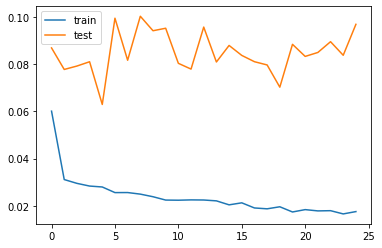

(38, 7)
(38, 7)
(38, 7)
score_train: [117.840] 129.6, 115.1, 115.7, 114.2, 112.6, 120.8, 116.1
(8, 1, 20)
score_test: [310.953] 435.1, 326.5, 129.2, 121.1, 462.6, 254.8, 265.8

RMSE test:  310.9526170433757 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0559 - val_loss: 0.0965
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0956
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.1024
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0959
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0979
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.0713
Epoch 7/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.1139
Epoch 8/1000
38/38 [======================

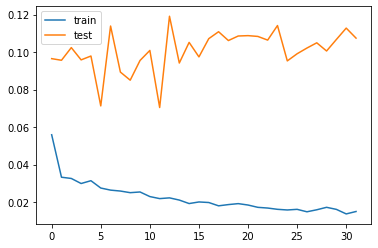

(38, 7)
(38, 7)
(38, 7)
score_train: [106.624] 103.7, 104.5, 115.4, 108.1, 102.8, 110.9, 100.3
(8, 1, 20)
score_test: [327.496] 516.1, 346.0, 150.2, 93.1, 438.9, 276.3, 253.9

RMSE test:  327.4957259634318 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0709 - val_loss: 0.1022
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0345 - val_loss: 0.1001
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0889
Epoch 4/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0811
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0974
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.1027
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0264 - val_loss: 0.0871
Epoch 8/1000
38/38 [=======================

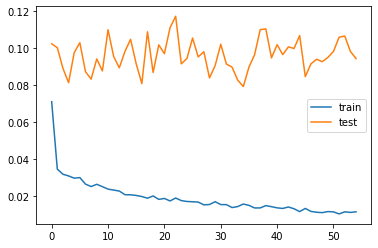

(38, 7)
(38, 7)
(38, 7)
score_train: [91.684] 84.8, 91.6, 95.3, 92.4, 91.9, 99.8, 85.0
(8, 1, 20)
score_test: [306.534] 517.4, 355.9, 88.0, 72.3, 338.0, 213.1, 301.3

RMSE test:  306.53421301158767 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0410 - val_loss: 0.0918
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0373 - val_loss: 0.1036
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.0945
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0880
Epoch 5/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0796
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.0886
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0264 - val_loss: 0.0898
Epoch 8/1000
38/38 [==============================]

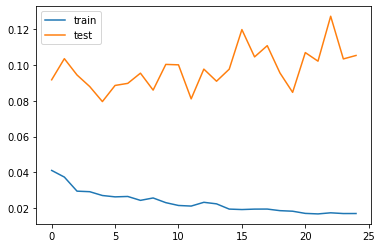

(38, 7)
(38, 7)
(38, 7)
score_train: [115.202] 116.4, 115.8, 118.1, 113.0, 114.3, 116.4, 112.2
(8, 1, 20)
score_test: [324.398] 472.5, 337.0, 36.0, 153.6, 463.7, 272.4, 292.7

RMSE test:  324.39829052714856 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0589 - val_loss: 0.0881
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.1118
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.1026
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.0911
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0260 - val_loss: 0.1091
Epoch 6/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0925
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0264 - val_loss: 0.1153
Epoch 8/1000
38/38 [======================

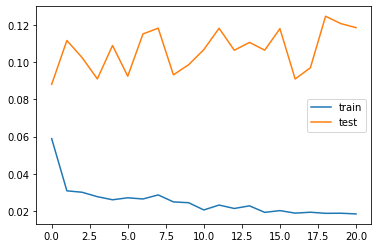

(38, 7)
(38, 7)
(38, 7)
score_train: [120.761] 126.5, 122.5, 119.1, 120.8, 114.5, 120.5, 121.0
(8, 1, 20)
score_test: [344.174] 461.1, 333.7, 66.6, 212.6, 476.7, 325.3, 350.0

RMSE test:  344.1737956868117 

8  	10    	272.819	5.68434e-14	272.819	272.819

Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0511 - val_loss: 0.0736
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0573
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0744
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0787
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0893
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0538
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.0

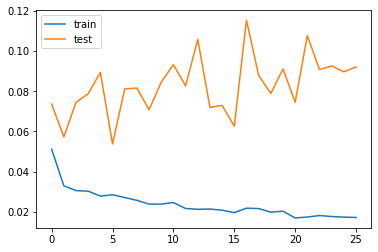

(38, 7)
(38, 7)
(38, 7)
score_train: [119.010] 127.6, 118.1, 118.6, 116.3, 115.1, 121.7, 115.2
(8, 1, 20)
score_test: [303.008] 401.4, 296.1, 132.9, 136.2, 458.4, 289.5, 252.5

RMSE test:  303.00785432038015 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0589 - val_loss: 0.0781
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0913
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0727
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1020
Epoch 5/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0746
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0257 - val_loss: 0.1004
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.0992
Epoch 8/1000
38/38 [=====================

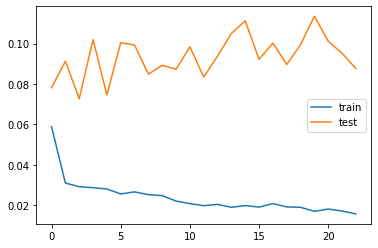

(38, 7)
(38, 7)
(38, 7)
score_train: [118.894] 119.4, 114.7, 115.2, 120.7, 119.0, 126.2, 116.7
(8, 1, 20)
score_test: [295.757] 436.8, 317.1, 146.8, 115.1, 430.9, 231.6, 216.5

RMSE test:  295.7566167017901 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0800
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0816
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0941
Epoch 4/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0865
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.0828
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0237 - val_loss: 0.0874
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0832
Epoch 8/1000
38/38 [======================

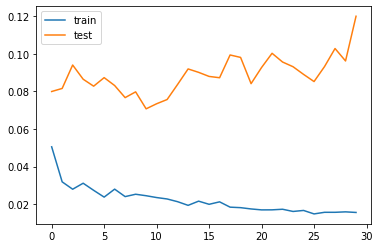

(38, 7)
(38, 7)
(38, 7)
score_train: [124.970] 122.5, 122.3, 118.8, 109.4, 116.9, 126.9, 153.3
(8, 1, 20)
score_test: [346.189] 494.0, 376.2, 64.6, 143.8, 443.6, 275.3, 394.9

RMSE test:  346.18903165976417 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0653 - val_loss: 0.1027
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.1017
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0943
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.1076
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.0865
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0263 - val_loss: 0.0962
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0241 - val_loss: 0.0785
Epoch 8/1000
38/38 [======================

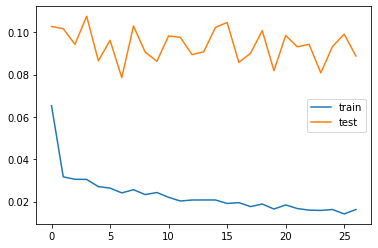

(38, 7)
(38, 7)
(38, 7)
score_train: [118.674] 124.0, 113.7, 118.2, 134.1, 115.3, 118.8, 104.5
(8, 1, 20)
score_test: [297.653] 416.6, 315.5, 97.4, 158.4, 418.6, 223.6, 295.3

RMSE test:  297.6531348699366 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0551 - val_loss: 0.1020
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0836
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0975
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1107
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0257 - val_loss: 0.0889
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0259 - val_loss: 0.0844
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0249 - val_loss: 0.0875
Epoch 8/1000
38/38 [=======================

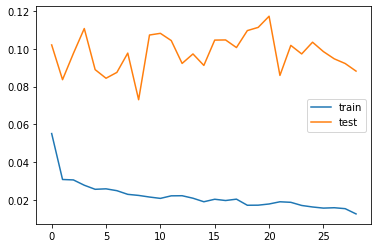

(38, 7)
(38, 7)
(38, 7)
score_train: [109.838] 115.5, 110.6, 108.4, 106.0, 103.7, 111.5, 112.7
(8, 1, 20)
score_test: [296.614] 414.3, 319.3, 106.3, 163.5, 436.4, 222.2, 253.8

RMSE test:  296.6136332185303 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 12ms/step - loss: 0.0463 - val_loss: 0.0866
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.0804
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0819
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.0706
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0878
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0248 - val_loss: 0.0988
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0252 - val_loss: 0.0855
Epoch 8/1000
38/38 [=====================

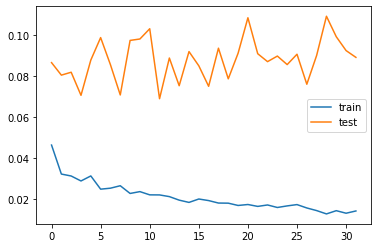

(38, 7)
(38, 7)
(38, 7)
score_train: [104.404] 105.2, 103.9, 111.6, 103.4, 98.1, 109.2, 98.7
(8, 1, 20)
score_test: [298.227] 438.3, 326.4, 144.1, 77.3, 394.2, 249.6, 282.0

RMSE test:  298.2273432019823 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0528 - val_loss: 0.0805
Epoch 2/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0773
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0909
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0805
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0740
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.0878
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0246 - val_loss: 0.0946
Epoch 8/1000
38/38 [=========================

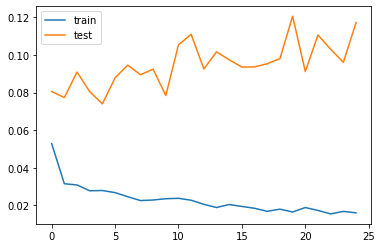

(38, 7)
(38, 7)
(38, 7)
score_train: [116.658] 118.4, 112.1, 118.2, 116.0, 110.5, 123.2, 117.7
(8, 1, 20)
score_test: [342.010] 500.0, 377.7, 145.7, 110.6, 424.2, 320.6, 331.6

RMSE test:  342.0095304108844 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0580 - val_loss: 0.0819
Epoch 2/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0946
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0761
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0867
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0738
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.0860
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0255 - val_loss: 0.0894
Epoch 8/1000
38/38 [======================

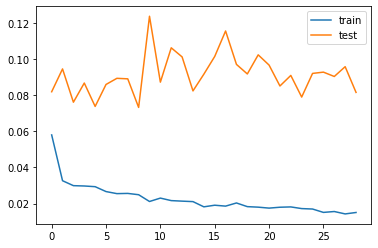

(38, 7)
(38, 7)
(38, 7)
score_train: [111.937] 114.0, 114.6, 112.8, 111.3, 100.7, 116.8, 112.7
(8, 1, 20)
score_test: [285.299] 428.2, 284.8, 166.4, 127.1, 418.5, 208.0, 207.7

RMSE test:  285.2985579915256 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0692 - val_loss: 0.0964
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0335 - val_loss: 0.0854
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.1046
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0888
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.0850
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.0802
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.1006
Epoch 8/1000
38/38 [======================

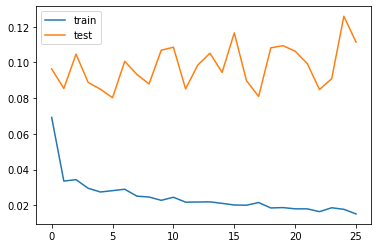

(38, 7)
(38, 7)
(38, 7)
score_train: [117.429] 120.5, 121.0, 117.3, 117.2, 112.9, 118.1, 114.7
(8, 1, 20)
score_test: [333.432] 466.1, 350.6, 64.3, 198.7, 481.9, 263.6, 304.7

RMSE test:  333.43175053883436 

9  	9     	272.819	5.68434e-14	272.819	272.819

Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0596 - val_loss: 0.0713
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.1090
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0724
Epoch 4/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0936
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0727
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.0850
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.

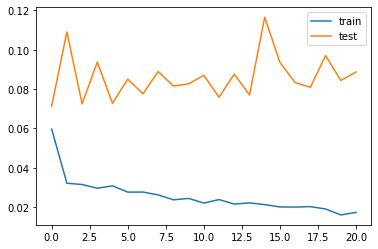

(38, 7)
(38, 7)
(38, 7)
score_train: [121.394] 127.0, 123.7, 121.6, 115.9, 113.4, 126.5, 120.9
(8, 1, 20)
score_test: [297.396] 425.9, 294.5, 38.9, 174.2, 428.4, 258.6, 262.2

RMSE test:  297.39578466172514 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0570 - val_loss: 0.0828
Epoch 2/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0912
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.0826
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0822
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.0865
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.0796
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0253 - val_loss: 0.0964
Epoch 8/1000
38/38 [======================

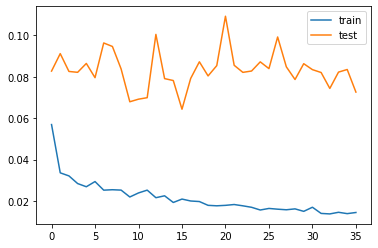

(38, 7)
(38, 7)
(38, 7)
score_train: [109.376] 107.0, 107.0, 109.8, 108.9, 107.4, 113.1, 112.2
(8, 1, 20)
score_test: [269.254] 410.1, 285.0, 99.4, 111.5, 387.9, 220.4, 191.6

RMSE test:  269.2537037350828 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0456 - val_loss: 0.0790
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0759
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0747
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0636
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0883
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0681
Epoch 7/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0887
Epoch 8/1000
38/38 [=======================

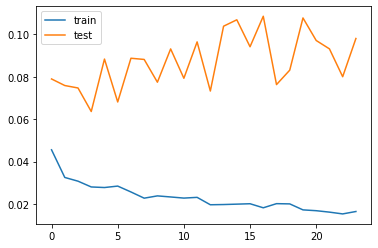

(38, 7)
(38, 7)
(38, 7)
score_train: [114.614] 121.6, 107.7, 114.5, 112.1, 110.6, 121.2, 113.8
(8, 1, 20)
score_test: [312.801] 421.9, 372.0, 112.1, 152.5, 406.3, 287.9, 291.0

RMSE test:  312.8010888733268 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0726
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0765
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0826
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.0780
Epoch 5/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0891
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0895
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.0912
Epoch 8/1000
38/38 [======================

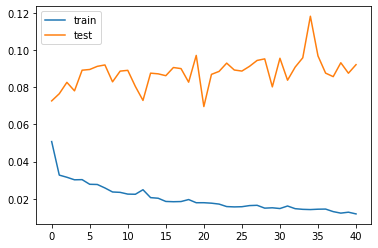

(38, 7)
(38, 7)
(38, 7)
score_train: [102.615] 100.5, 103.4, 107.9, 97.8, 97.9, 108.3, 102.0
(8, 1, 20)
score_test: [303.177] 476.3, 376.0, 165.8, 106.8, 351.7, 232.8, 241.8

RMSE test:  303.1771570383162 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0432 - val_loss: 0.0703
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.1100
Epoch 3/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0594
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0841
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0255 - val_loss: 0.0691
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.0755
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0247 - val_loss: 0.0798
Epoch 8/1000
38/38 [========================

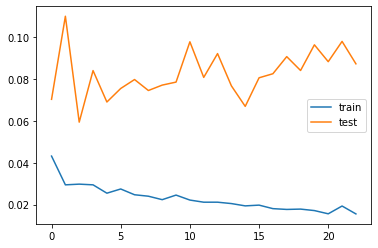

(38, 7)
(38, 7)
(38, 7)
score_train: [118.090] 128.7, 117.4, 114.9, 115.0, 116.5, 120.7, 112.6
(8, 1, 20)
score_test: [295.169] 382.9, 296.5, 116.4, 150.3, 442.9, 260.4, 274.3

RMSE test:  295.16928342369954 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 12ms/step - loss: 0.0422 - val_loss: 0.0913
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0330 - val_loss: 0.0937
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.1076
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0834
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.0879
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.1017
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0260 - val_loss: 0.0830
Epoch 8/1000
38/38 [====================

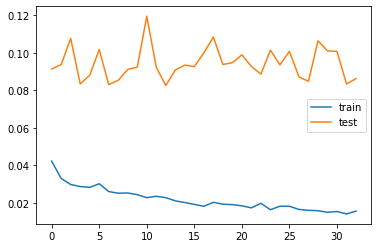

(38, 7)
(38, 7)
(38, 7)
score_train: [109.387] 116.1, 108.9, 106.6, 107.7, 109.0, 110.6, 106.5
(8, 1, 20)
score_test: [293.309] 438.8, 284.2, 145.1, 119.8, 375.2, 274.4, 278.2

RMSE test:  293.3092756275366 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0473 - val_loss: 0.0796
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.1021
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0789
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0899
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.1054
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.0872
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0256 - val_loss: 0.0988
Epoch 8/1000
38/38 [======================

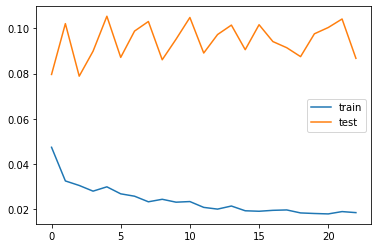

(38, 7)
(38, 7)
(38, 7)
score_train: [122.370] 124.7, 115.8, 126.9, 120.2, 120.5, 127.8, 120.2
(8, 1, 20)
score_test: [294.268] 416.4, 289.9, 154.1, 140.3, 407.6, 258.5, 268.8

RMSE test:  294.2676227118234 


Units CNN1:  255 ,Sequence size:  4
(38, 1, 20)
Epoch 1/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0625 - val_loss: 0.0974
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0900
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.1148
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.1063
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0903
Epoch 6/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0810
Epoch 7/1000
38/38 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.0939
Epoch 8/1000
38/38 [======================

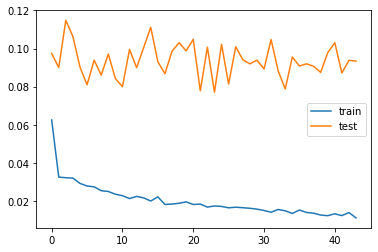

(38, 7)
(38, 7)
(38, 7)
score_train: [96.951] 97.2, 96.0, 102.9, 96.8, 95.6, 101.8, 87.6
(8, 1, 20)
score_test: [305.291] 497.1, 325.8, 137.5, 141.2, 377.8, 253.0, 231.3

RMSE test:  305.2910774287353 

10 	8     	270.323	1.63398    	269.254	272.819


In [76]:
population_size = 10
num_generations = 10
# 8 bits for ltsm1 , 8 for lstm 2 , 6 for sequence length , 21 for features selections
# 8 bits for cnn1 ,8 bits for cnn2 , 8 bits for lstm 2 ,8 bits for lstm 2 , 6 bits for sequence length , 21 for features selections
gene_length =14 #58

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.9)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.7)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)
population = toolbox.population(n = population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
#param cxpb: The probability of mating two individuals.
#param mutpb: The probability of mutating an individual.
population , logbook  = algorithms.eaSimple(population, toolbox,halloffame=hof, cxpb = 0.7, mutpb = 0.6,stats=stats, ngen = num_generations, verbose = True)

In [77]:
print('Best score :', best_score)

Best score : 269.2537037350828


In [78]:
model=model_name
model.summary()

Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_92 (Conv1D)           (None, 1, 255)            10455     
_________________________________________________________________
flatten_92 (Flatten)         (None, 255)               0         
_________________________________________________________________
dropout_92 (Dropout)         (None, 255)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 7)                 1792      
Total params: 12,247
Trainable params: 12,247
Non-trainable params: 0
_________________________________________________________________


In [79]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# make a prediction
yhat = model.predict(X_test[[0,7]])
yhat.shape 

(2, 7)

In [80]:
yhat = yhat.reshape(-1, yhat.shape[-1])

In [81]:
#yhat

In [82]:
# invert scaling for forecast
y_test_pred = scaler2.inverse_transform(yhat)
#print(inv_yhat)
# invert scaling for actual
Y_test_true =Y_test[[0,7]]
Y_test_true = Y_test_true.reshape(-1, Y_test_true.shape[-1])
y_test_true= scaler2.inverse_transform(Y_test_true)
#print(inv_y)

In [83]:
days

DatetimeIndex(['2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
               '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09',
               '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
               '2020-08-14', '2020-08-15'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [84]:
test_res=pd.DataFrame()
test_res['Prediction']=y_test_pred.flatten()[0:14]
test_res['real']=y_test_true.flatten()[0:14]
test_res.set_index(days,inplace=True)

In [85]:
test_res

,Prediction,real
timestamp,,
2020-08-02,796.561768,693.0
2020-08-03,667.758911,522.0
2020-08-04,705.362793,659.0
2020-08-05,886.032593,1021.0
2020-08-06,884.652161,1283.0
2020-08-07,852.745056,1144.0
2020-08-08,794.696777,1018.0
2020-08-09,774.302612,1345.0
2020-08-10,854.192993,1230.0


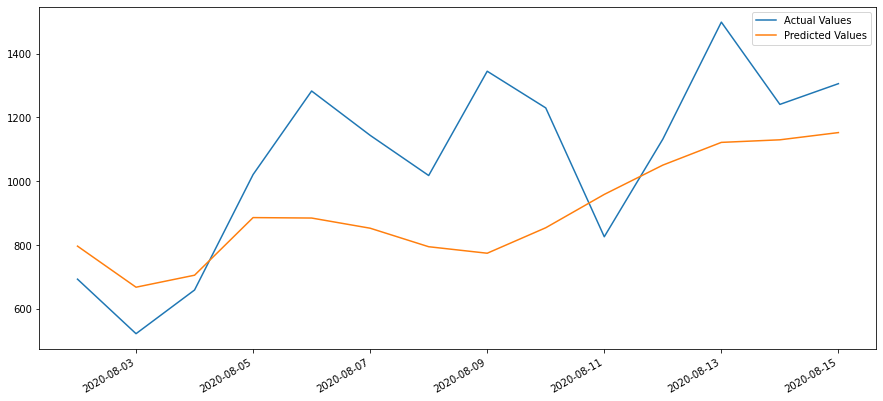

In [86]:

import pandas as pd
import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()




In [87]:
import numpy as np 
from sklearn import metrics
print('Test Metrics')
print('MSE:', round(metrics.mean_squared_error(test_res['real'], test_res['Prediction']), 2))
print('RMSE:',round( np.sqrt(metrics.mean_squared_error(test_res['real'], test_res['Prediction'])), 2))
print('MAE:', round(metrics.mean_absolute_error(test_res['real'], test_res['Prediction']), 2))
print('R Squared:', round( metrics.r2_score(test_res['real'], test_res['Prediction']), 2))
print('Max Error:',round(  metrics.max_error(test_res['real'], test_res['Prediction']), 2))


Test Metrics
MSE: 72497.56
RMSE: 269.25
MAE: 224.7
R Squared: 0.08
Max Error: 570.7


In [88]:
# make a prediction
y_train_pred = model.predict(X_train)
y_train_pred .shape

(38, 7)

In [89]:
y_train_pred = y_train_pred.reshape(y_train_pred.shape[0], y_train_pred.shape[1])
y_train_pred.shape

(38, 7)

In [90]:

# invert scaling for forecast

y_train_pred = scaler2.inverse_transform(y_train_pred)
Y_train_true = Y_train.reshape((len(Y_train), n_out))

y_train_real = scaler2.inverse_transform(Y_train_true )

In [91]:

# Flatten for final errors
Y_train_pred_bis = y_train_pred.flatten()
Y_train_real_bis = y_train_real.flatten()

In [92]:
y_train_pred[0]

array([762.14746, 817.0816 , 715.7248 , 741.1527 , 709.6484 , 795.0866 ,
       896.7345 ], dtype=float32)

In [93]:
#For plot 
#filter_indices = [0,7,14,21,28,35,42,49,56,63,70,77,84,91,98,105]
filter_indices = [0,7,14,21,28]
y_train_pred = y_train_pred [filter_indices ]

In [94]:
# Part of train dataset
y_train_real= y_train_real[filter_indices]
Y_train_pred = y_train_pred.flatten()
Y_train_real = y_train_real.flatten()

In [95]:
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
date_train = df.loc[mask].date.sort_index(axis = 0) 
X_train.shape

(38, 1, 20)

In [96]:
date_train.head(7)

23033   2020-06-15
23034   2020-06-16
23035   2020-06-17
23036   2020-06-18
23037   2020-06-19
23038   2020-06-20
23039   2020-06-21
Name: date, dtype: datetime64[ns]

In [97]:
taille_x = date_train.shape[0] - nb_seq
taille_x 

44

In [98]:
date_train = date_train.values.flatten()

In [99]:
prediction_train = pd.DataFrame(columns=['date_to_prediction','true_value','predict'])

In [100]:
Y_train_pred.shape

(35,)

In [101]:
Y_train_real.shape

(35,)

In [102]:
date_train.shape

(48,)

In [103]:
date_train[nb_seq:].shape

(44,)

In [104]:
suite_size = Y_train_real.shape[0]- date_train[nb_seq:].shape[0]
suite_size 

-9

In [105]:
Y_train_real[:-suite_size].shape

(9,)

In [106]:
date_train[nb_seq:].shape

(44,)

In [107]:
Y_train_pred[:-suite_size].shape

(9,)

In [108]:
Y_train_real[:-suite_size].shape

(9,)

In [109]:
date_trainX = date_train[nb_seq:]

In [110]:
date_trainX[0:Y_train_pred.shape[0]].shape

(35,)

In [111]:
prediction_train['date_to_prediction'] = date_trainX[0:Y_train_pred.shape[0]]
prediction_train['predict'] = Y_train_pred
prediction_train['true_value'] = Y_train_real


In [112]:
prediction_train['date_to_prediction'] = pd.to_datetime(prediction_train['date_to_prediction'], infer_datetime_format=True)

In [113]:
prediction_train.set_index('date_to_prediction',inplace=True)

In [114]:
prediction_train.head(20)

,true_value,predict
date_to_prediction,,
2020-06-19,572.364075,762.147461
2020-06-20,1006.548401,817.081604
2020-06-21,676.681091,715.724792
2020-06-22,665.403564,741.152710
2020-06-23,683.259644,709.648376
2020-06-24,586.460938,795.086609
2020-06-25,1104.286987,896.734497
2020-06-26,905.050781,844.949463
2020-06-27,777.238892,764.053223


In [115]:
prediction_train.tail(10)

,true_value,predict
date_to_prediction,,
2020-07-14,679.500488,760.570374
2020-07-15,651.306702,716.909668
2020-07-16,655.065857,747.255676
2020-07-17,652.246521,729.604126
2020-07-18,783.817505,783.065063
2020-07-19,771.600159,851.159851
2020-07-20,707.694214,843.534424
2020-07-21,806.372498,835.186951
2020-07-22,669.162781,819.691650


"\nfig, ax = plt.subplots(figsize=(15,7))\nplt.plot(test_res.index, test_res['real'],  label='Actual Values')\nplt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')\n# If you don't like the break in the graph, change 90 to 89 in the above line\nplt.gcf().autofmt_xdate()\nplt.legend()\nplt.show()\n"

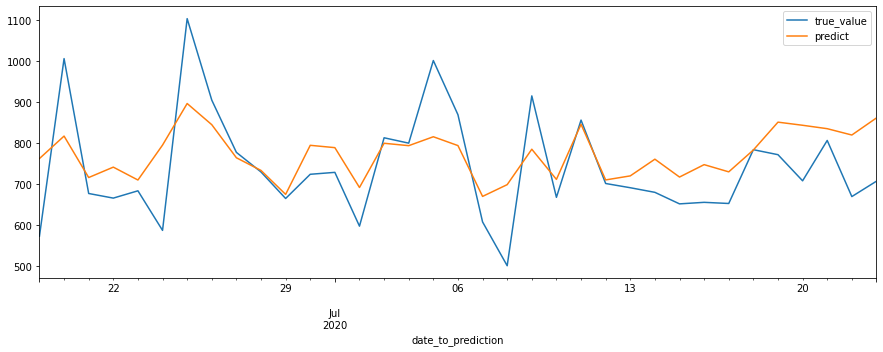

In [116]:
# Prédiction du train vs la réalité 
prediction_train.plot(figsize=(15,5))
'''
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()
'''

In [117]:
print('Trains Metrics')
loss = tf.keras.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis )
print('MSE',"{:.2f}".format(loss))
rmse = tf.sqrt(tf.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis ))
print('RMSE',"{:.2f}".format(rmse))
loss2 = tf.keras.losses.MAE(Y_train_real_bis, Y_train_pred_bis )
print('MAE',"{:.2f}".format(loss2))
r2 =r2_score(Y_train_real_bis, Y_train_pred_bis )
print('R2',"{:.2f}".format(r2))
maxerror=max_error(Y_train_real_bis, Y_train_pred_bis )
print('maxError',"{:.2f}".format(maxerror))

Trains Metrics
MSE 11963.15
RMSE 109.38
MAE 85.99
R2 0.66
maxError 287.02
